In [1]:
import os
import torch
import copy
import tensorflow as tf
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
# from Downloads import LSTMSudokuClassifier as LSTMC
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from random import randint

from tqdm import tqdm_notebook
tqdm_notebook.monitor_interval = 0

In [2]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, n_label, batch_size, n_layers, use_gpu):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        self.n_layers = n_layers
               
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, n_layers, bidirectional=True)
        self.lstm2 = nn.LSTM(input_dim, hidden_dim, n_layers, bidirectional=True)
        self.lstm3 = nn.LSTM(input_dim, hidden_dim, n_layers, bidirectional=True)
        
        self.hidden2label = nn.Sequential(torch.nn.Linear(2*hidden_dim, n_label),
                                          torch.nn.Softmax(dim = -1))
        self.r_hidden = self.init_hidden()
        self.c_hidden = self.init_hidden()
        self.s_hidden = self.init_hidden()

    def init_hidden(self):
        if self.use_gpu:
            h0 = Variable(torch.zeros(2*n_layers, self.batch_size, self.hidden_dim).cuda())
            c0 = Variable(torch.zeros(2*n_layers, self.batch_size, self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(2*n_layers, self.batch_size, self.hidden_dim))
            c0 = Variable(torch.zeros(2*n_layers, self.batch_size, self.hidden_dim))
        return (h0, c0)
    
    def ManipulateSquare(self, lstm_out_square):
        counter = 0
        inner_stack = None
        outer_stack = None
        for i in range(3):
            for j in range(3):
                x = lstm_out_square[counter,:,:]
                counter += 1
                x = x.view(3,3,2*hidden_dim)#change to 2*hidden_dim
                if inner_stack is None:
                    inner_stack = x
                else:
                    inner_stack = torch.cat((inner_stack,x),1)        
            if outer_stack is None:
#                 print(inner_stack.shape)
                outer_stack = inner_stack
                inner_stack = None
#                 print('B = ',outer_stack)
            else:
#                 print(inner_stack.shape)
                outer_stack = torch.cat((outer_stack,inner_stack),0)
#                 print('B = ',outer_stack)
                inner_stack = None
        return outer_stack

    def forward(self, row_tensor, col_tensor, square_tensor):
        
        lstm_out_row, hidden_row = self.lstm1(row_tensor, self.r_hidden)
        lstm_out_col, hidden_col = self.lstm2(col_tensor, self.c_hidden)
        lstm_out_square, hidden_square = self.lstm3(square_tensor, self.s_hidden)
        
#         self.r_hidden = hidden_row
#         self.c_hidden = hidden_col
#         self.s_hidden = hidden_square
        
        # Do manipulation Here
        #Row & Col Manipulation
        row_col = lstm_out_row + lstm_out_col +lstm_out_square 
        #Square Manipulation
        lstm_out = row_col 
        lstm_out_tensor = lstm_out
#         if self.use_gpu:
#             lstm_out_tensor = lstm_out.cuda()
#         print("final tensor", lstm_out_tensor.shape, lstm_out_tensor)
        
        #Sum Square Row Col
        y  = self.hidden2label(lstm_out_tensor)
#         print('Output Shape ', y.shape)
        return y

In [3]:
class InputGrid():
    
    def __init__(self, Grid):
        self.Grid = Grid
        self.gridLength = len(Grid[0])
#         self.labels = labels
        
    def getlims(self, i):
        if 0 <= i <= 2:
            rowlims = [0,3]
        elif 3 <= i <= 5:
            rowlims = [3,6]
        elif 6 <= i <= 8:
                rowlims = [6,9]
        return rowlims

    def get_square(self, i):
        grid_square = None
        if i < 3:
            if i%3 == 0:
                grid_square = self.Grid[0:3,0:3]
            elif i%3 == 1:
                grid_square = self.Grid[0:3,3:6]
            elif i%3 == 2:
                grid_square = self.Grid[0:3,6:9]
        elif i < 6:
            if i%3 == 0:
                grid_square = self.Grid[3:6,0:3]
            elif i%3 == 1:
                grid_square = self.Grid[3:6,3:6]
            elif i%3 == 2:
                grid_square = self.Grid[3:6,6:9]
        elif i < 9:
            if i%3 == 0:
                grid_square = self.Grid[6:9,0:3]
            elif i%3 == 1:
                grid_square = self.Grid[6:9,3:6]
            elif i%3 == 2:
                grid_square = self.Grid[6:9,6:9]
        return grid_square.flatten()
                
    
    # takes 1D returns 2D
    def one_hot(self, vec):
        one_hot_matrix = []
        for val in vec:
            hot_vec = [0 for _ in range(9)]
            if val > 0:
                hot_vec[int(val)-1] = 1
            one_hot_matrix.append(hot_vec)
        real_one_hot = np.array(one_hot_matrix)
        return real_one_hot
    
    #takes 2D returns 3D
    def getInput(self):
#         print(self.Grid)
        Rows = np.zeros((9,9,9))
        Columns = np.zeros((9,9,9))
        Squares = np.zeros((9,9,9))
        Labels = np.zeros((9,9,9))
        for i in range(self.gridLength):
            hot_row = self.one_hot(self.Grid[i,:])
            hot_column = self.one_hot(self.Grid[:,i])
            hot_square = self.one_hot(self.get_square(i))
#             hot_label = self.one_hot(self.labels[i,:])
            
            Rows[i] = hot_row
            Columns[i] = hot_column
            Squares[i] = hot_square
#             Labels[i] = hot_label
        
        Rows = np.reshape (Rows , (1, 81, 9))
        Columns = np.reshape (Columns, (1, 81, 9))
        Squares = np.reshape (Squares, (1, 81, 9))
        Rows = np.transpose (Rows, ((1, 0, 2)))
        Columns = np.transpose (Columns, ((1, 0, 2)))
        Squares = np.transpose (Squares, ((1, 0, 2)))

        row_tensor = Variable(torch.FloatTensor(Rows))
        col_tensor = Variable(torch.FloatTensor(Columns))
        square_tensor = Variable(torch.FloatTensor(Squares))
#         label_tensor = Variable(torch.LongTensor(Labels))
#         print(row_tensor)
#         print(col_tensor)
#         print(square_tensor)
#         print(label_tensor)
                 
        return row_tensor, col_tensor, square_tensor

In [9]:
# use_plot = True
# use_save = True
# if use_save:
#     import pickle
#     from datetime import datetime

DATA_DIR = 'data'
TRAIN_FILE = 'kaggle_sudoku.csv'
TEST_FILE = 'test.csv'
TRAIN_LABEL = 'train_label.txt'
TEST_LABEL = 'test_label.txt'

In [10]:
class SudokuDataset(Dataset):
    def __init__(self, fpath):
        
        print(fpath)
        lines = open(fpath, 'r').read().splitlines()[1:]
        nsamples = len(lines)

        X = np.zeros((nsamples, 9*9), np.float32)  
        Y = np.zeros((nsamples, 9*9), np.int32) 

        for i, line in enumerate(lines):
            quiz, solution = line.split(",")
            for j, (q, s) in enumerate(zip(quiz, solution)):
                X[i, j], Y[i, j] = q, s
            if i>=nsamples-1:
                break

        X = np.reshape(X, (-1, 9, 9))
        Y = np.reshape(Y, (-1, 9, 9))
        Y -= 1
        self.X = X
        self.Y = Y
#         print(Y)
#         print(Y.shape)

    def __getitem__(self, index):
        quiz = self.X[index]
        sol = self.Y[index]
        return quiz, sol
    
    def __len__(self):
        return len(self.X)

In [7]:
if __name__=='__main__':
    
    ## parameter setting
    epochs = 100
    batch_size = 1
    use_gpu = torch.cuda.is_available()
    learning_rate = 0.001

    input_dim = 9
    hidden_dim = 200
    n_label = 9
    n_layers = 3
    
    train_path = os.path.join(DATA_DIR, TRAIN_FILE)
    test_path = os.path.join(DATA_DIR, TEST_FILE)
    save_filepath = 'rnn-3-100-1000.pt'


     ### ********************create model**************************
    model = LSTMClassifier(input_dim, hidden_dim, n_label, batch_size, n_layers, use_gpu)
    if use_gpu:
        model = model.cuda()
    
    training_set = SudokuDataset(train_path)
    train_loader = DataLoader(training_set,
                          batch_size,
                          shuffle=True,
                          num_workers=0
                          )
    
    print('TRAINING')

    optimizer = optim.Adam(model.parameters())
    loss_function = nn.CrossEntropyLoss()
    train_loss_ = []
    test_loss_ = []
    train_acc_ = []
    test_acc_ = []
    
    
    def adjust_learning_rate(optimizer, epoch):
        lr = learning_rate * (0.1 ** (epoch // 10))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return optimizer
    
    import pdb
    nsamples = 1000//batch_size

### training procedure

#     t = trange(100, desc='Bar desc', leave=True)
    for epoch in range(epochs):
#         optimizer = adjust_learning_rate(optimizer, epoch)
        total_acc = 0.0
        total_loss = 0.0
        total = 0.0

#         model.hidden = model.init_hidden()

#         t = trange(100000, desc='RNN', leave=True)
        for i, traindata in zip(tqdm_notebook(range(nsamples)), train_loader):
#             traindata = train_loader[i]
            model.zero_grad()
            train_inputs_raw, train_labels_raw = traindata
#             print(train_inputs_raw.shape)

            train_data_numpy = Variable(train_inputs_raw).data.numpy()
            train_labels_numpy = Variable(train_labels_raw).data.numpy()
            train_labels = Variable(torch.LongTensor(train_labels_numpy[0]))

#             pdb.set_trace ()
            input_grid = InputGrid(train_data_numpy[0])
            row_tensor, col_tensor, square_tensor = input_grid.getInput()

            if use_gpu:
                row_tensor, col_tensor, square_tensor, train_labels = \
                        row_tensor.cuda(), col_tensor.cuda(), square_tensor.cuda(), train_labels.cuda()

            model.hidden = model.init_hidden()
            model.batch_size =  batch_size 
            output = model(row_tensor, col_tensor, square_tensor)
            output = output.view(81,9)


#             for i in range(output.size()[1]):
            loss = loss_function(output, train_labels.view(81,))
            loss.backward()
            optimizer.step()

            # calc training acc
            _, predicted = torch.max(output.data, 1)
#             print(predicted.shape)
#             print('TrainPred =  ',predicted, 'While TrainLabel = ' ,train_labels.data)
            acc = (predicted == train_labels.data.view(81)).sum()/81
#             print(acc)
            total += 81
#             print(loss.data[0])
#             print (acc)

#        print("loss:", loss.data[0], "acc", total_acc)
            train_loss_.append(loss.data[0])
            train_acc_.append(acc)

#             t.set_description("Bar desc (file %i)" % iter)
#             tqdm.refresh(self=) # t/o show immediately the update

        print('[Epoch: %3d/%3d] Training Loss: %.3f, Training Acc: %.3f' 
                  % (epoch, epochs, np.mean(train_loss_), np.mean (train_acc_)))
    torch.save(model.state_dict(), save_filepath+'_'+str(epoch))


data\kaggle_sudoku.csv
TRAINING


A Jupyter Widget

Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\Akrofi\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Akrofi\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Akrofi\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




[Epoch:   0/100] Training Loss: 1.874, Training Acc: 0.475


A Jupyter Widget


[Epoch:   1/100] Training Loss: 1.856, Training Acc: 0.495


A Jupyter Widget


[Epoch:   2/100] Training Loss: 1.847, Training Acc: 0.506


A Jupyter Widget


[Epoch:   3/100] Training Loss: 1.840, Training Acc: 0.515


A Jupyter Widget


[Epoch:   4/100] Training Loss: 1.833, Training Acc: 0.522


A Jupyter Widget


[Epoch:   5/100] Training Loss: 1.826, Training Acc: 0.531


A Jupyter Widget


[Epoch:   6/100] Training Loss: 1.819, Training Acc: 0.540


A Jupyter Widget


[Epoch:   7/100] Training Loss: 1.810, Training Acc: 0.550


A Jupyter Widget


[Epoch:   8/100] Training Loss: 1.801, Training Acc: 0.561


A Jupyter Widget


[Epoch:   9/100] Training Loss: 1.791, Training Acc: 0.573


A Jupyter Widget


[Epoch:  10/100] Training Loss: 1.780, Training Acc: 0.584


A Jupyter Widget


[Epoch:  11/100] Training Loss: 1.770, Training Acc: 0.595


A Jupyter Widget


[Epoch:  12/100] Training Loss: 1.760, Training Acc: 0.606


A Jupyter Widget


[Epoch:  13/100] Training Loss: 1.751, Training Acc: 0.616


A Jupyter Widget


[Epoch:  14/100] Training Loss: 1.742, Training Acc: 0.626


A Jupyter Widget


[Epoch:  15/100] Training Loss: 1.733, Training Acc: 0.634


A Jupyter Widget


[Epoch:  16/100] Training Loss: 1.726, Training Acc: 0.642


A Jupyter Widget


[Epoch:  17/100] Training Loss: 1.718, Training Acc: 0.650


A Jupyter Widget


[Epoch:  18/100] Training Loss: 1.712, Training Acc: 0.657


A Jupyter Widget


[Epoch:  19/100] Training Loss: 1.705, Training Acc: 0.663


A Jupyter Widget


[Epoch:  20/100] Training Loss: 1.700, Training Acc: 0.669


A Jupyter Widget


[Epoch:  21/100] Training Loss: 1.694, Training Acc: 0.675


A Jupyter Widget


[Epoch:  22/100] Training Loss: 1.689, Training Acc: 0.681


A Jupyter Widget


[Epoch:  23/100] Training Loss: 1.684, Training Acc: 0.686


A Jupyter Widget


[Epoch:  24/100] Training Loss: 1.679, Training Acc: 0.690


A Jupyter Widget


[Epoch:  25/100] Training Loss: 1.675, Training Acc: 0.695


A Jupyter Widget


[Epoch:  26/100] Training Loss: 1.671, Training Acc: 0.699


A Jupyter Widget


[Epoch:  27/100] Training Loss: 1.667, Training Acc: 0.703


A Jupyter Widget


[Epoch:  28/100] Training Loss: 1.663, Training Acc: 0.707


A Jupyter Widget


[Epoch:  29/100] Training Loss: 1.659, Training Acc: 0.711


A Jupyter Widget


[Epoch:  30/100] Training Loss: 1.656, Training Acc: 0.714


A Jupyter Widget


[Epoch:  31/100] Training Loss: 1.653, Training Acc: 0.718


A Jupyter Widget


[Epoch:  32/100] Training Loss: 1.650, Training Acc: 0.721


A Jupyter Widget


[Epoch:  33/100] Training Loss: 1.646, Training Acc: 0.724


A Jupyter Widget


[Epoch:  34/100] Training Loss: 1.644, Training Acc: 0.727


A Jupyter Widget


[Epoch:  35/100] Training Loss: 1.641, Training Acc: 0.730


A Jupyter Widget


[Epoch:  36/100] Training Loss: 1.638, Training Acc: 0.732


A Jupyter Widget


[Epoch:  37/100] Training Loss: 1.636, Training Acc: 0.735


A Jupyter Widget


[Epoch:  38/100] Training Loss: 1.633, Training Acc: 0.738


A Jupyter Widget


[Epoch:  39/100] Training Loss: 1.631, Training Acc: 0.740


A Jupyter Widget


[Epoch:  40/100] Training Loss: 1.628, Training Acc: 0.742


A Jupyter Widget


[Epoch:  41/100] Training Loss: 1.626, Training Acc: 0.745


A Jupyter Widget


[Epoch:  42/100] Training Loss: 1.624, Training Acc: 0.747


A Jupyter Widget


[Epoch:  43/100] Training Loss: 1.622, Training Acc: 0.749


A Jupyter Widget


[Epoch:  44/100] Training Loss: 1.620, Training Acc: 0.751


A Jupyter Widget


[Epoch:  45/100] Training Loss: 1.618, Training Acc: 0.753


A Jupyter Widget


[Epoch:  46/100] Training Loss: 1.616, Training Acc: 0.755


A Jupyter Widget


[Epoch:  47/100] Training Loss: 1.614, Training Acc: 0.757


A Jupyter Widget


[Epoch:  48/100] Training Loss: 1.612, Training Acc: 0.759


A Jupyter Widget


[Epoch:  49/100] Training Loss: 1.610, Training Acc: 0.761


A Jupyter Widget


[Epoch:  50/100] Training Loss: 1.609, Training Acc: 0.762


A Jupyter Widget


[Epoch:  51/100] Training Loss: 1.607, Training Acc: 0.764


A Jupyter Widget


[Epoch:  52/100] Training Loss: 1.605, Training Acc: 0.766


A Jupyter Widget


[Epoch:  53/100] Training Loss: 1.604, Training Acc: 0.767


A Jupyter Widget


[Epoch:  54/100] Training Loss: 1.602, Training Acc: 0.769


A Jupyter Widget


[Epoch:  55/100] Training Loss: 1.601, Training Acc: 0.770


A Jupyter Widget


[Epoch:  56/100] Training Loss: 1.599, Training Acc: 0.772


A Jupyter Widget


[Epoch:  57/100] Training Loss: 1.598, Training Acc: 0.773


A Jupyter Widget


[Epoch:  58/100] Training Loss: 1.597, Training Acc: 0.775


A Jupyter Widget


[Epoch:  59/100] Training Loss: 1.595, Training Acc: 0.776


A Jupyter Widget


[Epoch:  60/100] Training Loss: 1.594, Training Acc: 0.777


A Jupyter Widget


[Epoch:  61/100] Training Loss: 1.593, Training Acc: 0.779


A Jupyter Widget


[Epoch:  62/100] Training Loss: 1.591, Training Acc: 0.780


A Jupyter Widget


[Epoch:  63/100] Training Loss: 1.590, Training Acc: 0.781


A Jupyter Widget


[Epoch:  64/100] Training Loss: 1.589, Training Acc: 0.783


A Jupyter Widget


[Epoch:  65/100] Training Loss: 1.588, Training Acc: 0.784


A Jupyter Widget


[Epoch:  66/100] Training Loss: 1.586, Training Acc: 0.785


A Jupyter Widget


[Epoch:  67/100] Training Loss: 1.585, Training Acc: 0.786


A Jupyter Widget


[Epoch:  68/100] Training Loss: 1.584, Training Acc: 0.787


A Jupyter Widget


[Epoch:  69/100] Training Loss: 1.583, Training Acc: 0.788


A Jupyter Widget


[Epoch:  70/100] Training Loss: 1.582, Training Acc: 0.789


A Jupyter Widget


[Epoch:  71/100] Training Loss: 1.581, Training Acc: 0.791


A Jupyter Widget


[Epoch:  72/100] Training Loss: 1.580, Training Acc: 0.792


A Jupyter Widget


[Epoch:  73/100] Training Loss: 1.579, Training Acc: 0.793


A Jupyter Widget


[Epoch:  74/100] Training Loss: 1.578, Training Acc: 0.794


A Jupyter Widget


[Epoch:  75/100] Training Loss: 1.577, Training Acc: 0.795


A Jupyter Widget


[Epoch:  76/100] Training Loss: 1.576, Training Acc: 0.796


A Jupyter Widget


[Epoch:  77/100] Training Loss: 1.575, Training Acc: 0.797


A Jupyter Widget


[Epoch:  78/100] Training Loss: 1.574, Training Acc: 0.798


A Jupyter Widget


[Epoch:  79/100] Training Loss: 1.573, Training Acc: 0.798


A Jupyter Widget


[Epoch:  80/100] Training Loss: 1.572, Training Acc: 0.799


A Jupyter Widget


[Epoch:  81/100] Training Loss: 1.571, Training Acc: 0.800


A Jupyter Widget


[Epoch:  82/100] Training Loss: 1.570, Training Acc: 0.801


A Jupyter Widget


[Epoch:  83/100] Training Loss: 1.570, Training Acc: 0.802


A Jupyter Widget


[Epoch:  84/100] Training Loss: 1.569, Training Acc: 0.803


A Jupyter Widget


[Epoch:  85/100] Training Loss: 1.568, Training Acc: 0.804


A Jupyter Widget


[Epoch:  86/100] Training Loss: 1.567, Training Acc: 0.804


A Jupyter Widget


[Epoch:  87/100] Training Loss: 1.566, Training Acc: 0.805


A Jupyter Widget


[Epoch:  88/100] Training Loss: 1.565, Training Acc: 0.806


A Jupyter Widget


[Epoch:  89/100] Training Loss: 1.565, Training Acc: 0.807


A Jupyter Widget


[Epoch:  90/100] Training Loss: 1.564, Training Acc: 0.808


A Jupyter Widget


[Epoch:  91/100] Training Loss: 1.563, Training Acc: 0.808


A Jupyter Widget


[Epoch:  92/100] Training Loss: 1.562, Training Acc: 0.809


A Jupyter Widget


[Epoch:  93/100] Training Loss: 1.562, Training Acc: 0.810


A Jupyter Widget


[Epoch:  94/100] Training Loss: 1.561, Training Acc: 0.811


A Jupyter Widget


[Epoch:  95/100] Training Loss: 1.560, Training Acc: 0.811


A Jupyter Widget


[Epoch:  96/100] Training Loss: 1.560, Training Acc: 0.812


A Jupyter Widget


[Epoch:  97/100] Training Loss: 1.559, Training Acc: 0.813


A Jupyter Widget


[Epoch:  98/100] Training Loss: 1.558, Training Acc: 0.813


A Jupyter Widget


[Epoch:  99/100] Training Loss: 1.558, Training Acc: 0.814


In [62]:
### TEST
epochs = 100
batch_size = 1
use_gpu = torch.cuda.is_available()
learning_rate = 0.001

input_dim = 9
hidden_dim = 200
n_label = 9
n_layers = 3

train_path = os.path.join(DATA_DIR, TRAIN_FILE)
test_path = os.path.join(DATA_DIR, TEST_FILE)
save_filepath = 'rnn-3-100-1000.pt_99'


 ### ********************create model**************************
model = LSTMClassifier(input_dim, hidden_dim, n_label, batch_size, n_layers, use_gpu)
if use_gpu:
    model = model.cuda()    


model.load_state_dict(torch.load(save_filepath))
model.eval()

# original saved file with DataParallel
# state_dict = torch.load(save_filepath)
# # create new OrderedDict that does not contain `module.`
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     print(k,v)
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)
# model.eval()

total_acc = 0.0
total = 0.0

test_set = SudokuDataset(test_path)
test_loader = DataLoader(test_set,
                        batch_size,
                        shuffle=True,
                        num_workers=0
                        )
nsamples = 30
test_loss_ = []
test_acc_ = []
predictedStore = []
solutionStore = []
for i, testdata in zip(tqdm_notebook(range(nsamples)), test_loader):
    model.zero_grad()
    train_inputs_raw, train_labels_raw = testdata
#             print(train_inputs_raw.shape)

    train_data_numpy = Variable(train_inputs_raw).data.numpy()
    train_labels_numpy = Variable(train_labels_raw).data.numpy()
    train_labels = Variable(torch.LongTensor(train_labels_numpy[0]))

    input_grid = InputGrid(train_data_numpy[0])
    row_tensor, col_tensor, square_tensor = input_grid.getInput()

    if use_gpu:
        row_tensor, col_tensor, square_tensor, train_labels = \
                row_tensor.cuda(), col_tensor.cuda(), square_tensor.cuda(), train_labels.cuda()

    model.hidden = model.init_hidden()
    model.batch_size = batch_size 
    output = model(row_tensor, col_tensor, square_tensor)
    output = output.view(81,9)

#             for i in range(output.size()[1]):
#         loss = loss_function(output, train_labels.view(81,))
# #         loss.backward()
# #         optimizer.step()

    # calc training acc
    _, predicted = torch.max(output.data, 1)
    predictedStore.append(predicted.view(81,).cpu().numpy().tolist())
    solutionStore.append(train_labels.data.view(81,).cpu().numpy().tolist())
#     print('TrainPred = ', predicted.view(9,9), 'While TrainLabel = ' ,train_labels.data.view(9,9))
    acc = (predicted == train_labels.data.view(81)).sum()/81
#             print(acc)
#             print(loss.data[0])
#             print (acc)

#        print("loss:", loss.data[0], "acc", total_acc)
#     test_loss_.append(loss.data[0])
    test_acc_.append(acc)

#             t.set_description("Bar desc (file %i)" % iter)
#             tqdm.refresh(self=) # t/o show immediately the update

predictedStore = [i for arr in predictedStore for i in arr]
solutionStore = [i for arr in solutionStore for i in arr]

print(predictedStore)
print("-------------------------------------")
print(solutionStore)

print('[Epoch: %3d/%3d], Testing Acc: %.3f' % (1, 1, np.mean (test_acc_)))

np.savetxt("predictedStore.csv", predictedStore, delimiter=",", fmt='%s')
np.savetxt("solutionStore.csv", solutionStore, delimiter=",", fmt='%s')

data\test.csv


A Jupyter Widget


[0, 7, 5, 8, 2, 1, 4, 3, 0, 6, 8, 2, 5, 7, 8, 0, 6, 1, 4, 5, 0, 0, 3, 6, 1, 2, 8, 1, 4, 5, 1, 7, 0, 8, 6, 2, 5, 2, 0, 6, 2, 8, 1, 2, 7, 2, 3, 6, 1, 0, 7, 0, 4, 2, 0, 1, 0, 5, 6, 2, 0, 4, 8, 7, 0, 6, 6, 8, 0, 2, 3, 4, 2, 0, 6, 7, 1, 5, 7, 0, 8, 6, 8, 6, 5, 1, 0, 7, 6, 5, 3, 0, 1, 2, 7, 2, 8, 2, 5, 2, 7, 6, 8, 4, 0, 2, 3, 3, 7, 5, 3, 0, 8, 4, 1, 3, 3, 0, 2, 5, 4, 1, 6, 4, 7, 5, 0, 3, 6, 1, 2, 7, 5, 8, 0, 1, 1, 7, 2, 0, 6, 4, 5, 3, 1, 2, 7, 2, 5, 2, 1, 6, 7, 7, 8, 6, 6, 6, 4, 7, 0, 2, 2, 6, 4, 5, 7, 3, 0, 8, 1, 5, 4, 1, 3, 2, 8, 6, 7, 5, 0, 3, 8, 6, 7, 7, 2, 4, 4, 1, 5, 3, 8, 0, 3, 1, 8, 3, 6, 1, 7, 3, 0, 2, 2, 0, 5, 3, 6, 4, 3, 7, 1, 6, 2, 8, 7, 8, 1, 6, 4, 2, 7, 6, 3, 2, 6, 2, 8, 0, 5, 3, 1, 5, 7, 3, 2, 3, 4, 7, 6, 0, 8, 5, 4, 0, 3, 8, 2, 8, 1, 5, 7, 6, 5, 2, 4, 1, 7, 0, 3, 6, 4, 0, 7, 8, 4, 1, 5, 6, 3, 0, 7, 6, 1, 3, 2, 6, 2, 2, 1, 4, 0, 7, 5, 8, 1, 6, 3, 3, 0, 2, 8, 0, 4, 7, 2, 3, 2, 1, 5, 6, 4, 0, 8, 3, 4, 5, 7, 1, 0, 2, 3, 8, 3, 0, 3, 6, 4, 5, 7, 3, 1, 6, 1, 0, 7, 2, 8, 4, 5, 2, 7,

In [15]:
sn =  [4, 8, 9, 5, 3, 2, 7, 6, 1, 7, 1, 3, 4, 8, 6, 5, 9, 2, 5, 6, 2, 9, 1, 7, 8, 3, 4, 2, 5, 8, 3, 4, 1, 9, 7, 6, 6, 3, 1, 7, 5, 9, 2, 4, 8, 9, 4, 7, 2, 6, 8, 1, 5, 3, 1, 2, 5, 6, 7, 3, 4, 8, 9, 8, 7, 6, 1, 9, 4, 3, 2, 5, 3, 9, 4, 8, 2, 5, 6, 1, 7, 3, 5, 1, 8, 4, 9, 2, 6, 7, 2, 6, 4, 7, 5, 3, 8, 1, 9, 7, 8, 9, 1, 6, 2, 3, 5, 4, 4, 3, 2, 6, 7, 1, 5, 9, 8, 6, 9, 7, 5, 3, 8, 4, 2, 1, 5, 1, 8, 9, 2, 4, 6, 7, 3, 9, 4, 3, 2, 1, 5, 7, 8, 6, 8, 7, 5, 3, 9, 6, 1, 4, 2, 1, 2, 6, 4, 8, 7, 9, 3, 5, 9, 2, 8, 4, 6, 1, 5, 3, 7, 6, 4, 7, 5, 3, 8, 1, 2, 9, 5, 1, 3, 7, 9, 2, 4, 6, 8, 8, 7, 2, 1, 5, 6, 9, 4, 3, 3, 5, 9, 8, 4, 7, 2, 1, 6, 4, 6, 1, 9, 2, 3, 7, 8, 5, 7, 3, 6, 2, 1, 9, 8, 5, 4, 1, 8, 4, 3, 7, 5, 6, 9, 2, 2, 9, 5, 6, 8, 4, 3, 7, 1, 1, 6, 5, 4, 9, 8, 2, 7, 3, 9, 7, 8, 3, 2, 6, 4, 5, 1, 3, 4, 2, 1, 5, 7, 6, 9, 8, 4, 5, 7, 9, 1, 2, 8, 3, 6, 2, 8, 9, 6, 4, 3, 7, 1, 5, 6, 3, 1, 7, 8, 5, 9, 2, 4, 7, 9, 3, 8, 6, 1, 5, 4, 2, 8, 2, 4, 5, 3, 9, 1, 6, 7, 5, 1, 6, 2, 7, 4, 3, 8, 9, 6, 7, 3, 2, 8, 5, 4, 9, 1, 8, 1, 5, 9, 3, 4, 7, 2, 6, 9, 2, 4, 1, 7, 6, 5, 8, 3, 1, 6, 2, 8, 9, 7, 3, 4, 5, 4, 3, 8, 5, 2, 1, 9, 6, 7, 5, 9, 7, 6, 4, 3, 2, 1, 8, 2, 8, 1, 7, 5, 9, 6, 3, 4, 3, 5, 6, 4, 1, 2, 8, 7, 9, 7, 4, 9, 3, 6, 8, 1, 5, 2, 3, 2, 1, 4, 7, 9, 6, 8, 5, 4, 8, 9, 1, 5, 6, 3, 7, 2, 6, 7, 5, 2, 3, 8, 4, 9, 1, 5, 9, 3, 6, 8, 7, 2, 1, 4, 2, 6, 4, 3, 9, 1, 7, 5, 8, 7, 1, 8, 5, 2, 4, 9, 3, 6, 8, 3, 6, 7, 1, 2, 5, 4, 9, 1, 5, 2, 9, 4, 3, 8, 6, 7, 9, 4, 7, 8, 6, 5, 1, 2, 3, 5, 7, 4, 9, 6, 1, 2, 3, 8, 9, 1, 8, 3, 2, 7, 5, 4, 6, 2, 6, 3, 8, 4, 5, 7, 9, 1, 6, 8, 2, 1, 3, 4, 9, 5, 7, 4, 3, 9, 5, 7, 6, 8, 1, 2, 7, 5, 1, 2, 8, 9, 4, 6, 3, 8, 9, 5, 6, 1, 2, 3, 7, 4, 1, 2, 7, 4, 5, 3, 6, 8, 9, 3, 4, 6, 7, 9, 8, 1, 2, 5, 4, 5, 2, 9, 1, 6, 7, 8, 3, 6, 8, 3, 2, 4, 7, 5, 1, 9, 7, 9, 1, 3, 5, 8, 6, 2, 4, 8, 7, 9, 4, 2, 1, 3, 5, 6, 1, 2, 4, 5, 6, 3, 8, 9, 7, 3, 6, 5, 7, 8, 9, 1, 4, 2, 2, 1, 8, 6, 7, 4, 9, 3, 5, 9, 4, 6, 1, 3, 5, 2, 7, 8, 5, 3, 7, 8, 9, 2, 4, 6, 1, 6, 1, 7, 2, 5, 9, 3, 4, 8, 8, 2, 3, 4, 1, 6, 5, 7, 9, 4, 9, 5, 7, 8, 3, 6, 1, 2, 9, 3, 2, 1, 6, 4, 7, 8, 5, 5, 4, 6, 8, 7, 2, 1, 9, 3, 7, 8, 1, 9, 3, 5, 2, 6, 4, 1, 5, 8, 3, 9, 7, 4, 2, 6, 2, 6, 9, 5, 4, 1, 8, 3, 7, 3, 7, 4, 6, 2, 8, 9, 5, 1, 2, 3, 7, 4, 8, 5, 1, 6, 9, 4, 5, 6, 1, 3, 9, 7, 8, 2, 1, 8, 9, 7, 2, 6, 3, 4, 5, 3, 6, 1, 5, 4, 7, 2, 9, 8, 7, 2, 4, 3, 9, 8, 5, 1, 6, 8, 9, 5, 2, 6, 1, 4, 3, 7, 9, 1, 2, 6, 7, 3, 8, 5, 4, 5, 7, 8, 9, 1, 4, 6, 2, 3, 6, 4, 3, 8, 5, 2, 9, 7, 1, 9, 2, 7, 4, 6, 8, 1, 3, 5, 8, 3, 5, 9, 7, 1, 6, 2, 4, 4, 6, 1, 2, 5, 3, 9, 7, 8, 1, 4, 9, 3, 8, 7, 5, 6, 2, 3, 5, 6, 1, 9, 2, 4, 8, 7, 2, 7, 8, 6, 4, 5, 3, 9, 1, 5, 9, 2, 7, 1, 6, 8, 4, 3, 6, 1, 3, 8, 2, 4, 7, 5, 9, 7, 8, 4, 5, 3, 9, 2, 1, 6, 9, 1, 2, 3, 4, 5, 6, 7, 8, 3, 4, 6, 2, 7, 8, 5, 9, 1, 5, 7, 8, 6, 9, 1, 2, 4, 3, 4, 3, 5, 7, 1, 2, 8, 6, 9, 6, 2, 7, 5, 8, 9, 3, 1, 4, 1, 8, 9, 4, 6, 3, 7, 2, 5, 7, 5, 1, 8, 2, 4, 9, 3, 6, 8, 6, 4, 9, 3, 7, 1, 5, 2, 2, 9, 3, 1, 5, 6, 4, 8, 7, 2, 5, 9, 1, 3, 7, 6, 8, 4, 4, 6, 1, 8, 2, 9, 5, 7, 3, 3, 7, 8, 4, 5, 6, 9, 2, 1, 6, 9, 3, 2, 1, 5, 8, 4, 7, 1, 4, 5, 3, 7, 8, 2, 9, 6, 7, 8, 2, 6, 9, 4, 3, 1, 5, 5, 2, 6, 7, 8, 1, 4, 3, 9, 8, 1, 4, 9, 6, 3, 7, 5, 2, 9, 3, 7, 5, 4, 2, 1, 6, 8, 4, 7, 1, 9, 3, 2, 6, 5, 8, 2, 6, 8, 4, 5, 1, 3, 7, 9, 9, 3, 5, 8, 7, 6, 1, 4, 2, 6, 9, 3, 5, 1, 8, 7, 2, 4, 8, 2, 4, 7, 6, 9, 5, 3, 1, 1, 5, 7, 3, 2, 4, 8, 9, 6, 7, 4, 6, 1, 9, 5, 2, 8, 3, 5, 8, 2, 6, 4, 3, 9, 1, 7, 3, 1, 9, 2, 8, 7, 4, 6, 5, 2, 1, 4, 5, 3, 8, 7, 6, 9, 5, 7, 6, 9, 4, 2, 3, 1, 8, 9, 3, 8, 1, 6, 7, 4, 2, 5, 4, 5, 9, 3, 7, 1, 2, 8, 6, 7, 2, 1, 6, 8, 5, 9, 3, 4, 8, 6, 3, 4, 2, 9, 5, 7, 1, 6, 9, 7, 8, 5, 3, 1, 4, 2, 3, 8, 5, 2, 1, 4, 6, 9, 7, 1, 4, 2, 7, 9, 6, 8, 5, 3, 7, 3, 4, 5, 2, 9, 6, 8, 1, 5, 1, 9, 8, 4, 6, 7, 2, 3, 8, 6, 2, 1, 7, 3, 4, 5, 9, 1, 4, 5, 7, 8, 2, 9, 3, 6, 9, 2, 7, 6, 3, 1, 5, 4, 8, 3, 8, 6, 9, 5, 4, 1, 7, 2, 2, 5, 1, 4, 6, 8, 3, 9, 7, 6, 7, 3, 2, 9, 5, 8, 1, 4, 4, 9, 8, 3, 1, 7, 2, 6, 5, 8, 7, 9, 6, 5, 4, 3, 1, 2, 4, 5, 2, 1, 3, 9, 6, 8, 7, 6, 1, 3, 7, 2, 8, 5, 9, 4, 9, 6, 5, 4, 8, 7, 1, 2, 3, 1, 8, 7, 3, 9, 2, 4, 5, 6, 3, 2, 4, 5, 1, 6, 9, 7, 8, 7, 9, 1, 8, 4, 3, 2, 6, 5, 5, 3, 6, 2, 7, 1, 8, 4, 9, 2, 4, 8, 9, 6, 5, 7, 3, 1, 1, 9, 5, 2, 4, 7, 6, 8, 3, 4, 7, 6, 3, 5, 8, 9, 2, 1, 2, 3, 8, 9, 1, 6, 5, 7, 4, 5, 8, 9, 7, 3, 4, 2, 1, 6, 3, 6, 4, 1, 9, 2, 7, 5, 8, 7, 2, 1, 6, 8, 5, 4, 3, 9, 9, 5, 3, 4, 2, 1, 8, 6, 7, 8, 1, 7, 5, 6, 9, 3, 4, 2, 6, 4, 2, 8, 7, 3, 1, 9, 5, 6, 5, 7, 3, 4, 8, 1, 2, 9, 2, 9, 8, 1, 5, 7, 4, 3, 6, 4, 1, 3, 6, 2, 9, 5, 8, 7, 8, 4, 9, 5, 7, 1, 3, 6, 2, 3, 6, 1, 2, 9, 4, 7, 5, 8, 7, 2, 5, 8, 6, 3, 9, 4, 1, 1, 3, 4, 7, 8, 6, 2, 9, 5, 9, 8, 2, 4, 1, 5, 6, 7, 3, 5, 7, 6, 9, 3, 2, 8, 1, 4, 2, 1, 7, 3, 6, 9, 8, 4, 5, 4, 8, 9, 5, 1, 7, 6, 2, 3, 5, 6, 3, 4, 2, 8, 9, 7, 1, 8, 3, 5, 6, 7, 2, 1, 9, 4, 1, 9, 6, 8, 3, 4, 2, 5, 7, 7, 4, 2, 1, 9, 5, 3, 8, 6, 6, 2, 4, 7, 8, 1, 5, 3, 9, 3, 7, 8, 9, 5, 6, 4, 1, 2, 9, 5, 1, 2, 4, 3, 7, 6, 8, 3, 8, 1, 6, 4, 9, 5, 7, 2, 2, 5, 9, 7, 8, 3, 1, 6, 4, 7, 4, 6, 5, 1, 2, 3, 8, 9, 9, 3, 5, 8, 7, 6, 2, 4, 1, 1, 2, 8, 3, 9, 4, 6, 5, 7, 6, 7, 4, 2, 5, 1, 9, 3, 8, 5, 9, 3, 4, 2, 8, 7, 1, 6, 8, 6, 2, 1, 3, 7, 4, 9, 5, 4, 1, 7, 9, 6, 5, 8, 2, 3, 7, 8, 9, 4, 1, 5, 3, 2, 6, 2, 1, 6, 8, 3, 9, 7, 5, 4, 4, 5, 3, 7, 2, 6, 8, 9, 1, 8, 9, 7, 1, 6, 3, 2, 4, 5, 6, 4, 1, 5, 8, 2, 9, 3, 7, 3, 2, 5, 9, 4, 7, 1, 6, 8, 5, 7, 8, 2, 9, 4, 6, 1, 3, 9, 6, 4, 3, 7, 1, 5, 8, 2, 1, 3, 2, 6, 5, 8, 4, 7, 9, 9, 7, 1, 2, 6, 4, 3, 8, 5, 8, 5, 4, 7, 3, 1, 6, 9, 2, 2, 6, 3, 8, 9, 5, 7, 4, 1, 5, 9, 2, 1, 8, 6, 4, 7, 3, 6, 3, 7, 4, 2, 9, 5, 1, 8, 4, 1, 8, 3, 5, 7, 2, 6, 9, 7, 4, 9, 5, 1, 3, 8, 2, 6, 3, 2, 6, 9, 4, 8, 1, 5, 7, 1, 8, 5, 6, 7, 2, 9, 3, 4, 4, 6, 9, 7, 8, 3, 2, 5, 1, 3, 2, 7, 6, 5, 1, 8, 9, 4, 8, 1, 5, 2, 9, 4, 3, 6, 7, 1, 3, 6, 9, 2, 8, 4, 7, 5, 9, 8, 4, 3, 7, 5, 1, 2, 6, 7, 5, 2, 4, 1, 6, 9, 8, 3, 6, 7, 8, 1, 3, 2, 5, 4, 9, 5, 4, 3, 8, 6, 9, 7, 1, 2, 2, 9, 1, 5, 4, 7, 6, 3, 8, 2, 5, 3, 4, 6, 1, 8, 7, 9, 8, 7, 9, 3, 5, 2, 6, 1, 4, 6, 4, 1, 8, 9, 7, 2, 5, 3, 7, 1, 8, 5, 3, 9, 4, 6, 2, 4, 2, 5, 1, 8, 6, 9, 3, 7, 9, 3, 6, 7, 2, 4, 5, 8, 1, 3, 8, 2, 9, 7, 5, 1, 4, 6, 5, 6, 4, 2, 1, 3, 7, 9, 8, 1, 9, 7, 6, 4, 8, 3, 2, 5, 5, 9, 3, 6, 7, 2, 1, 4, 8, 6, 1, 2, 4, 8, 3, 9, 5, 7, 4, 8, 7, 9, 5, 1, 3, 2, 6, 8, 6, 5, 1, 9, 4, 7, 3, 2, 1, 3, 9, 7, 2, 6, 4, 8, 5, 7, 2, 4, 5, 3, 8, 6, 9, 1, 2, 4, 8, 3, 1, 7, 5, 6, 9, 3, 5, 1, 8, 6, 9, 2, 7, 4, 9, 7, 6, 2, 4, 5, 8, 1, 3, 9, 4, 3, 5, 8, 6, 2, 1, 7, 7, 8, 6, 2, 1, 4, 9, 3, 5, 2, 1, 5, 9, 7, 3, 4, 6, 8, 4, 6, 7, 3, 5, 1, 8, 9, 2, 3, 2, 9, 4, 6, 8, 7, 5, 1, 8, 5, 1, 7, 2, 9, 6, 4, 3, 5, 3, 8, 6, 9, 7, 1, 2, 4, 1, 9, 2, 8, 4, 5, 3, 7, 6, 6, 7, 4, 1, 3, 2, 5, 8, 9, 2, 4, 7, 3, 6, 8, 9, 1, 5, 1, 6, 3, 9, 5, 4, 8, 7, 2, 5, 8, 9, 2, 1, 7, 3, 6, 4, 6, 2, 4, 5, 3, 9, 7, 8, 1, 3, 1, 5, 8, 7, 2, 6, 4, 9, 7, 9, 8, 6, 4, 1, 2, 5, 3, 4, 7, 6, 1, 2, 3, 5, 9, 8, 8, 5, 2, 4, 9, 6, 1, 3, 7, 9, 3, 1, 7, 8, 5, 4, 2, 6, 5, 4, 7, 9, 1, 2, 6, 8, 3, 8, 9, 3, 6, 7, 5, 2, 1, 4, 6, 2, 1, 8, 4, 3, 9, 7, 5, 3, 7, 9, 4, 8, 6, 1, 5, 2, 1, 5, 8, 3, 2, 9, 7, 4, 6, 2, 6, 4, 1, 5, 7, 8, 3, 9, 7, 3, 5, 2, 9, 1, 4, 6, 8, 9, 8, 6, 7, 3, 4, 5, 2, 1, 4, 1, 2, 5, 6, 8, 3, 9, 7, 3, 9, 7, 6, 5, 4, 2, 8, 1, 5, 4, 2, 9, 8, 1, 3, 7, 6, 1, 8, 6, 7, 3, 2, 9, 4, 5, 8, 7, 3, 4, 9, 6, 1, 5, 2, 2, 6, 4, 5, 1, 7, 8, 3, 9, 9, 5, 1, 3, 2, 8, 7, 6, 4, 7, 2, 5, 1, 4, 3, 6, 9, 8, 4, 3, 8, 2, 6, 9, 5, 1, 7, 6, 1, 9, 8, 7, 5, 4, 2, 3]

pred =  [4, 8, 9, 5, 3, 2, 7, 6, 1, 7, 1, 3, 4, 8, 6, 5, 9, 2, 5, 6, 2, 9, 1, 7, 8, 3, 4, 2, 5, 8, 3, 4, 1, 9, 7, 6, 6, 3, 1, 7, 5, 9, 2, 4, 8, 9, 4, 7, 2, 6, 8, 1, 5, 3, 1, 2, 5, 6, 7, 3, 4, 8, 9, 8, 7, 6, 1, 9, 4, 3, 2, 5, 3, 9, 4, 8, 2, 5, 6, 1, 7, 3, 5, 1, 8, 4, 9, 2, 6, 7, 2, 6, 4, 7, 5, 3, 8, 1, 9, 7, 8, 9, 1, 6, 2, 3, 5, 4, 4, 3, 2, 6, 7, 1, 5, 9, 8, 6, 9, 7, 5, 3, 8, 4, 2, 1, 5, 1, 8, 9, 2, 4, 6, 7, 3, 9, 4, 3, 2, 1, 5, 7, 8, 6, 8, 7, 5, 3, 9, 6, 1, 4, 2, 1, 2, 6, 4, 8, 7, 9, 3, 5, 9, 2, 8, 4, 6, 1, 5, 3, 7, 6, 4, 7, 5, 3, 8, 1, 2, 9, 5, 1, 3, 7, 9, 2, 4, 6, 8, 8, 7, 2, 1, 5, 6, 9, 4, 3, 3, 5, 9, 8, 4, 7, 2, 1, 6, 4, 6, 1, 9, 2, 3, 7, 8, 5, 7, 3, 6, 2, 1, 9, 8, 5, 4, 1, 8, 4, 3, 7, 5, 6, 9, 2, 2, 9, 5, 6, 8, 4, 3, 7, 1, 1, 6, 5, 4, 9, 8, 2, 7, 3, 9, 7, 8, 3, 2, 6, 4, 5, 1, 3, 4, 2, 1, 5, 7, 6, 9, 8, 4, 5, 7, 9, 1, 2, 8, 3, 6, 2, 8, 9, 6, 4, 3, 7, 1, 5, 6, 3, 1, 7, 8, 5, 9, 2, 4, 7, 9, 3, 8, 6, 1, 5, 4, 2, 8, 2, 4, 5, 3, 9, 1, 6, 7, 5, 1, 6, 2, 7, 4, 3, 8, 9, 6, 7, 3, 2, 8, 5, 4, 9, 1, 8, 1, 5, 9, 3, 4, 7, 2, 6, 9, 2, 4, 1, 7, 6, 5, 8, 3, 1, 6, 2, 8, 9, 7, 3, 4, 5, 4, 3, 8, 5, 2, 1, 9, 6, 7, 5, 9, 7, 6, 4, 3, 2, 1, 8, 2, 8, 1, 7, 5, 9, 6, 3, 4, 3, 5, 6, 4, 1, 2, 8, 7, 9, 7, 4, 9, 3, 6, 8, 1, 5, 2, 3, 2, 1, 4, 7, 9, 6, 8, 5, 4, 8, 9, 1, 5, 6, 3, 7, 2, 6, 7, 5, 2, 3, 8, 4, 9, 1, 5, 9, 3, 6, 8, 7, 2, 1, 4, 2, 6, 4, 3, 9, 1, 7, 5, 8, 7, 1, 8, 5, 2, 4, 9, 3, 6, 8, 3, 6, 7, 1, 2, 5, 4, 9, 1, 5, 2, 9, 4, 3, 8, 6, 7, 9, 4, 7, 8, 6, 5, 1, 2, 3, 5, 7, 4, 9, 6, 1, 2, 3, 8, 9, 1, 8, 3, 7, 2, 5, 4, 6, 2, 6, 3, 8, 4, 5, 7, 9, 1, 6, 3, 5, 1, 8, 4, 9, 5, 7, 4, 2, 9, 6, 3, 7, 8, 1, 2, 7, 8, 1, 2, 5, 9, 4, 6, 3, 8, 9, 2, 5, 1, 6, 3, 7, 4, 1, 5, 7, 4, 2, 3, 6, 8, 9, 3, 4, 6, 7, 9, 8, 1, 2, 5, 4, 2, 1, 5, 9, 6, 7, 8, 3, 7, 9, 3, 1, 4, 8, 5, 2, 6, 6, 5, 8, 3, 7, 2, 4, 1, 9, 8, 7, 9, 4, 2, 1, 3, 6, 5, 1, 4, 2, 6, 5, 3, 8, 9, 7, 3, 6, 5, 7, 8, 9, 1, 4, 2, 9, 8, 7, 2, 1, 4, 6, 3, 8, 5, 1, 6, 9, 3, 7, 2, 5, 4, 2, 3, 4, 8, 6, 5, 9, 7, 1, 6, 1, 7, 2, 5, 9, 3, 4, 8, 8, 2, 3, 4, 1, 6, 5, 7, 9, 4, 9, 5, 7, 8, 3, 6, 1, 2, 9, 3, 1, 1, 6, 4, 7, 8, 5, 5, 4, 6, 8, 7, 2, 2, 9, 3, 7, 8, 2, 9, 3, 5, 1, 6, 4, 1, 5, 8, 3, 9, 7, 4, 2, 6, 2, 6, 9, 5, 4, 1, 8, 3, 7, 3, 7, 4, 6, 2, 8, 9, 5, 1, 2, 3, 6, 5, 8, 4, 1, 7, 9, 4, 5, 7, 1, 3, 9, 6, 8, 2, 1, 8, 9, 7, 2, 6, 3, 4, 5, 3, 6, 4, 8, 9, 1, 2, 5, 7, 7, 2, 8, 3, 4, 5, 9, 1, 6, 9, 1, 5, 2, 6, 7, 4, 3, 8, 5, 1, 2, 6, 7, 3, 8, 9, 4, 6, 7, 1, 9, 1, 8, 5, 2, 3, 8, 9, 3, 4, 5, 2, 7, 6, 1, 9, 2, 7, 4, 6, 8, 3, 1, 5, 8, 3, 5, 9, 7, 1, 6, 2, 4, 4, 6, 1, 2, 5, 3, 9, 7, 8, 1, 4, 9, 3, 8, 7, 5, 6, 2, 8, 5, 6, 1, 9, 2, 4, 3, 7, 3, 7, 2, 6, 4, 5, 8, 9, 1, 5, 8, 2, 7, 3, 9, 1, 4, 6, 6, 1, 3, 8, 2, 4, 7, 5, 9, 7, 9, 4, 5, 1, 6, 2, 8, 3, 2, 1, 4, 3, 9, 5, 6, 7, 8, 6, 3, 5, 2, 7, 8, 4, 9, 1, 9, 7, 8, 6, 4, 1, 2, 5, 3, 4, 9, 6, 5, 1, 3, 8, 2, 7, 1, 5, 7, 4, 8, 2, 3, 6, 9, 3, 8, 2, 7, 6, 9, 1, 4, 5, 7, 2, 1, 8, 5, 4, 9, 3, 6, 8, 6, 8, 9, 3, 7, 5, 1, 4, 5, 4, 3, 1, 2, 6, 7, 8, 2, 2, 5, 9, 1, 3, 7, 6, 8, 4, 4, 6, 3, 8, 2, 9, 5, 7, 1, 8, 7, 1, 4, 5, 6, 9, 2, 3, 6, 9, 8, 2, 1, 5, 3, 4, 7, 1, 4, 5, 3, 7, 8, 2, 9, 6, 2, 3, 7, 6, 9, 4, 8, 1, 5, 5, 2, 6, 7, 8, 1, 4, 3, 9, 7, 8, 4, 9, 6, 3, 1, 5, 2, 9, 1, 3, 5, 4, 2, 7, 6, 8, 4, 7, 1, 9, 3, 2, 6, 5, 8, 2, 6, 8, 4, 5, 1, 3, 7, 9, 9, 3, 5, 8, 7, 6, 1, 4, 2, 6, 9, 3, 5, 1, 8, 7, 2, 4, 8, 2, 4, 7, 8, 6, 5, 3, 1, 1, 5, 7, 3, 2, 4, 8, 9, 6, 7, 4, 6, 1, 9, 5, 2, 8, 3, 5, 8, 2, 6, 4, 3, 9, 1, 7, 3, 1, 9, 2, 8, 7, 4, 6, 5, 2, 1, 9, 5, 8, 3, 7, 6, 4, 5, 7, 6, 9, 4, 2, 3, 1, 8, 3, 4, 8, 1, 6, 7, 9, 2, 5, 4, 5, 7, 3, 8, 1, 2, 8, 6, 1, 8, 2, 6, 7, 5, 4, 3, 9, 9, 6, 3, 4, 2, 8, 5, 7, 1, 7, 2, 6, 8, 5, 9, 1, 4, 2, 8, 3, 5, 2, 1, 4, 6, 9, 7, 1, 9, 4, 7, 1, 6, 8, 5, 3, 7, 3, 4, 5, 2, 9, 6, 8, 1, 5, 1, 9, 8, 4, 6, 7, 2, 3, 8, 6, 2, 1, 7, 3, 4, 5, 9, 1, 4, 5, 7, 8, 2, 9, 3, 6, 9, 2, 7, 6, 3, 1, 5, 4, 8, 3, 8, 6, 9, 5, 4, 1, 7, 2, 2, 5, 1, 4, 6, 8, 3, 9, 7, 6, 7, 3, 2, 9, 5, 8, 1, 4, 4, 9, 8, 3, 1, 7, 2, 6, 5, 8, 7, 9, 9, 5, 4, 3, 1, 2, 4, 5, 2, 1, 3, 6, 6, 8, 7, 6, 1, 3, 7, 2, 8, 5, 9, 4, 9, 6, 5, 4, 8, 7, 1, 2, 3, 1, 8, 7, 3, 9, 2, 4, 5, 6, 3, 2, 4, 6, 1, 5, 9, 7, 8, 7, 9, 1, 8, 4, 3, 2, 6, 5, 5, 3, 6, 2, 7, 1, 8, 4, 9, 2, 4, 8, 5, 6, 9, 7, 3, 1, 8, 9, 5, 1, 4, 2, 6, 7, 3, 4, 7, 6, 3, 5, 8, 9, 2, 1, 1, 3, 2, 9, 6, 7, 5, 8, 4, 5, 8, 9, 7, 1, 4, 2, 3, 6, 3, 2, 4, 6, 9, 5, 7, 1, 8, 7, 6, 1, 8, 2, 3, 4, 5, 9, 2, 5, 3, 4, 1, 1, 8, 6, 7, 9, 1, 7, 5, 8, 6, 3, 4, 2, 6, 4, 8, 2, 7, 9, 1, 9, 5, 6, 5, 7, 3, 4, 8, 1, 2, 9, 2, 9, 8, 1, 5, 7, 4, 3, 6, 4, 1, 3, 6, 2, 9, 5, 8, 7, 8, 4, 8, 5, 7, 1, 3, 6, 2, 3, 6, 1, 2, 9, 4, 7, 5, 8, 7, 2, 5, 8, 6, 3, 9, 4, 1, 1, 3, 4, 7, 8, 6, 2, 9, 5, 9, 8, 2, 4, 1, 5, 6, 7, 3, 5, 7, 6, 9, 3, 2, 8, 1, 4, 2, 1, 7, 3, 6, 9, 8, 4, 5, 4, 8, 9, 5, 1, 7, 6, 2, 3, 5, 6, 3, 4, 2, 8, 9, 7, 1, 8, 3, 5, 6, 7, 2, 1, 9, 4, 1, 9, 6, 8, 8, 4, 2, 5, 7, 7, 4, 2, 1, 9, 5, 3, 8, 6, 6, 2, 4, 7, 8, 1, 5, 3, 9, 3, 7, 8, 9, 5, 6, 4, 1, 2, 9, 5, 1, 2, 4, 3, 7, 6, 8, 3, 8, 1, 6, 4, 9, 5, 7, 2, 2, 5, 9, 7, 8, 3, 1, 6, 4, 7, 4, 6, 5, 1, 2, 3, 8, 9, 9, 3, 5, 8, 7, 6, 2, 4, 1, 1, 2, 8, 3, 9, 4, 6, 5, 7, 6, 7, 4, 2, 5, 1, 9, 3, 8, 5, 9, 3, 4, 2, 8, 7, 1, 6, 8, 6, 2, 1, 3, 7, 4, 9, 5, 4, 1, 7, 9, 6, 5, 8, 2, 3, 7, 8, 9, 4, 1, 5, 3, 2, 6, 2, 1, 6, 8, 3, 9, 7, 5, 4, 4, 5, 3, 7, 2, 6, 8, 9, 1, 8, 9, 7, 1, 6, 3, 2, 4, 5, 6, 4, 1, 5, 8, 2, 9, 3, 7, 3, 2, 5, 9, 4, 7, 1, 6, 8, 5, 7, 8, 2, 9, 4, 6, 1, 3, 9, 6, 4, 3, 7, 1, 5, 8, 2, 1, 3, 2, 6, 5, 8, 4, 7, 9, 7, 9, 1, 2, 6, 4, 3, 8, 5, 8, 5, 4, 7, 3, 1, 6, 9, 2, 6, 2, 3, 8, 9, 5, 7, 4, 1, 5, 6, 2, 1, 8, 9, 4, 7, 3, 9, 3, 7, 4, 2, 6, 5, 1, 8, 4, 1, 8, 3, 5, 7, 2, 6, 9, 2, 4, 9, 5, 1, 3, 8, 2, 6, 3, 7, 6, 9, 4, 8, 1, 5, 7, 1, 8, 5, 6, 7, 2, 9, 3, 4, 4, 6, 9, 7, 8, 3, 2, 5, 1, 3, 2, 7, 6, 5, 1, 8, 9, 4, 8, 1, 5, 2, 9, 4, 3, 6, 7, 1, 3, 6, 9, 2, 8, 4, 7, 5, 9, 8, 4, 3, 7, 5, 1, 2, 6, 7, 5, 2, 4, 1, 6, 9, 8, 3, 6, 7, 8, 1, 3, 2, 5, 4, 9, 5, 4, 3, 8, 6, 9, 7, 1, 2, 2, 9, 1, 5, 4, 7, 6, 3, 8, 2, 5, 3, 4, 6, 1, 8, 7, 9, 8, 7, 9, 3, 5, 2, 6, 1, 4, 6, 4, 1, 8, 9, 7, 2, 5, 3, 7, 1, 8, 5, 3, 9, 4, 6, 2, 4, 2, 5, 1, 8, 6, 9, 3, 7, 9, 3, 6, 7, 2, 4, 5, 8, 1, 3, 8, 2, 9, 7, 5, 1, 4, 6, 5, 6, 4, 2, 1, 3, 7, 9, 8, 1, 9, 7, 6, 4, 8, 3, 2, 5, 5, 9, 3, 6, 7, 2, 1, 4, 8, 6, 1, 2, 4, 8, 3, 9, 5, 7, 4, 8, 7, 9, 5, 1, 3, 2, 6, 8, 6, 5, 1, 9, 4, 7, 3, 2, 1, 3, 9, 7, 2, 6, 4, 8, 5, 7, 2, 4, 5, 3, 8, 6, 9, 1, 9, 4, 8, 3, 1, 7, 5, 6, 4, 2, 5, 1, 8, 6, 9, 2, 7, 3, 3, 7, 6, 2, 4, 5, 8, 1, 9, 9, 4, 3, 5, 8, 6, 2, 1, 7, 7, 8, 6, 2, 1, 4, 9, 3, 5, 2, 1, 5, 9, 7, 3, 4, 6, 8, 4, 6, 7, 3, 5, 1, 8, 9, 2, 3, 2, 9, 4, 6, 8, 7, 5, 1, 8, 5, 1, 7, 2, 9, 6, 4, 3, 5, 3, 8, 6, 9, 7, 1, 2, 4, 1, 9, 2, 8, 4, 5, 3, 7, 6, 6, 7, 4, 1, 3, 2, 5, 8, 9, 2, 4, 7, 3, 6, 8, 9, 1, 5, 1, 6, 3, 9, 5, 4, 8, 7, 2, 5, 8, 9, 2, 1, 7, 3, 6, 4, 6, 2, 4, 5, 3, 9, 7, 8, 1, 3, 1, 5, 8, 7, 2, 6, 4, 9, 7, 9, 8, 6, 4, 1, 2, 5, 3, 4, 7, 6, 1, 2, 3, 5, 9, 8, 8, 5, 2, 4, 8, 6, 1, 3, 7, 9, 3, 1, 7, 8, 5, 4, 2, 6, 5, 4, 7, 9, 1, 2, 6, 8, 3, 8, 9, 3, 6, 7, 5, 2, 1, 4, 6, 2, 1, 8, 4, 3, 9, 7, 5, 3, 7, 9, 4, 8, 6, 1, 5, 2, 1, 5, 8, 3, 2, 9, 7, 4, 6, 2, 6, 4, 1, 5, 7, 8, 3, 9, 7, 3, 5, 2, 9, 1, 4, 6, 8, 9, 8, 6, 7, 3, 4, 5, 2, 1, 4, 1, 2, 5, 6, 8, 3, 9, 7, 3, 9, 7, 6, 5, 4, 2, 8, 1, 5, 4, 2, 9, 8, 1, 3, 7, 6, 1, 8, 6, 7, 3, 2, 9, 4, 5, 8, 7, 3, 4, 9, 6, 1, 5, 2, 2, 6, 4, 5, 1, 7, 8, 3, 9, 9, 5, 1, 3, 2, 8, 7, 6, 4, 7, 2, 5, 1, 4, 3, 6, 9, 8, 4, 3, 8, 2, 6, 9, 5, 1, 7, 6, 1, 9, 8, 7, 5, 4, 2, 3]

predictedStore = [0, 7, 5, 8, 2, 1, 4, 3, 0, 6, 8, 2, 5, 7, 8, 0, 6, 1, 4, 5, 0, 0, 3, 6, 1, 2, 8, 1, 4, 5, 1, 7, 0, 8, 6, 2, 5, 2, 0, 6, 2, 8, 1, 2, 7, 2, 3, 6, 1, 0, 7, 0, 4, 2, 0, 1, 0, 5, 6, 2, 0, 4, 8, 7, 0, 6, 6, 8, 0, 2, 3, 4, 2, 0, 6, 7, 1, 5, 7, 0, 8, 6, 8, 6, 5, 1, 0, 7, 6, 5, 3, 0, 1, 2, 7, 2, 8, 2, 5, 2, 7, 6, 8, 4, 0, 2, 3, 3, 7, 5, 3, 0, 8, 4, 1, 3, 3, 0, 2, 5, 4, 1, 6, 4, 7, 5, 0, 3, 6, 1, 2, 7, 5, 8, 0, 1, 1, 7, 2, 0, 6, 4, 5, 3, 1, 2, 7, 2, 5, 2, 1, 6, 7, 7, 8, 6, 6, 6, 4, 7, 0, 2, 2, 6, 4, 5, 7, 3, 0, 8, 1, 5, 4, 1, 3, 2, 8, 6, 7, 5, 0, 3, 8, 6, 7, 7, 2, 4, 4, 1, 5, 3, 8, 0, 3, 1, 8, 3, 6, 1, 7, 3, 0, 2, 2, 0, 5, 3, 6, 4, 3, 7, 1, 6, 2, 8, 7, 8, 1, 6, 4, 2, 7, 6, 3, 2, 6, 2, 8, 0, 5, 3, 1, 5, 7, 3, 2, 3, 4, 7, 6, 0, 8, 5, 4, 0, 3, 8, 2, 8, 1, 5, 7, 6, 5, 2, 4, 1, 7, 0, 3, 6, 4, 0, 7, 8, 4, 1, 5, 6, 3, 0, 7, 6, 1, 3, 2, 6, 2, 2, 1, 4, 0, 7, 5, 8, 1, 6, 3, 3, 0, 2, 8, 0, 4, 7, 2, 3, 2, 1, 5, 6, 4, 0, 8, 3, 4, 5, 7, 1, 0, 2, 3, 8, 3, 0, 3, 6, 4, 5, 7, 3, 1, 6, 1, 0, 7, 2, 8, 4, 5, 2, 7, 6, 7, 5, 1, 3, 6, 2, 8, 0, 2, 6, 7, 8, 5, 8, 1, 4, 7, 3, 6, 4, 7, 0, 6, 5, 5, 4, 8, 1, 6, 8, 7, 7, 2, 1, 8, 1, 1, 8, 6, 5, 8, 1, 7, 4, 8, 3, 0, 8, 3, 5, 1, 2, 3, 7, 5, 4, 4, 8, 6, 8, 0, 8, 8, 8, 2, 0, 4, 5, 1, 7, 4, 4, 0, 6, 4, 1, 7, 4, 5, 3, 3, 2, 3, 8, 3, 0, 5, 1, 6, 3, 5, 2, 4, 3, 8, 4, 8, 7, 0, 3, 1, 2, 4, 6, 3, 5, 1, 1, 1, 2, 2, 8, 3, 7, 1, 1, 3, 6, 2, 5, 3, 4, 1, 8, 0, 4, 7, 6, 1, 5, 5, 6, 3, 1, 8, 0, 2, 7, 8, 3, 1, 4, 5, 6, 7, 8, 4, 2, 5, 1, 3, 2, 8, 0, 4, 1, 7, 5, 4, 0, 6, 8, 7, 5, 2, 0, 3, 4, 8, 7, 4, 0, 6, 8, 2, 6, 3, 5, 6, 6, 5, 7, 2, 4, 7, 0, 7, 1, 2, 1, 8, 2, 0, 0, 6, 4, 8, 7, 0, 5, 4, 1, 8, 5, 3, 4, 4, 2, 7, 4, 5, 6, 0, 1, 8, 4, 8, 5, 7, 3, 4, 2, 1, 1, 5, 1, 8, 0, 7, 7, 3, 4, 8, 5, 0, 6, 8, 4, 5, 2, 3, 6, 5, 7, 2, 3, 5, 0, 7, 1, 8, 1, 1, 3, 6, 7, 7, 4, 0, 1, 8, 2, 2, 7, 5, 6, 6, 8, 4, 2, 3, 5, 0, 0, 1, 0, 8, 5, 6, 0, 7, 4, 2, 5, 5, 3, 3, 0, 4, 5, 1, 5, 6, 2, 2, 8, 1, 5, 8, 8, 4, 0, 7, 5, 8, 4, 6, 3, 0, 1, 4, 4, 0, 5, 5, 6, 6, 2, 7, 3, 7, 1, 8, 6, 6, 7, 0, 4, 8, 6, 0, 5, 6, 0, 2, 3, 5, 5, 4, 7, 1, 7, 4, 3, 5, 6, 1, 0, 1, 1, 2, 5, 2, 0, 8, 2, 2, 4, 1, 7, 7, 1, 1, 5, 8, 7, 3, 0, 7, 2, 3, 1, 3, 3, 1, 8, 2, 8, 5, 7, 7, 0, 2, 5, 7, 3, 4, 6, 2, 3, 2, 1, 7, 0, 0, 2, 3, 4, 1, 4, 8, 5, 7, 6, 3, 5, 1, 3, 4, 1, 7, 4, 1, 6, 7, 8, 3, 5, 1, 2, 4, 0, 3, 2, 6, 5, 6, 0, 4, 8, 5, 1, 8, 6, 4, 3, 7, 3, 1, 2, 2, 0, 7, 5, 1, 3, 4, 6, 2, 8, 3, 2, 1, 0, 1, 6, 7, 5, 1, 1, 4, 2, 7, 8, 1, 3, 6, 0, 8, 5, 3, 7, 2, 6, 2, 1, 3, 6, 3, 0, 6, 7, 3, 0, 4, 0, 5, 2, 3, 5, 1, 7, 5, 5, 4, 5, 8, 7, 0, 2, 8, 6, 3, 5, 1, 6, 4, 6, 8, 5, 6, 5, 2, 3, 4, 8, 3, 1, 1, 4, 8, 6, 1, 3, 5, 2, 0, 1, 4, 2, 3, 6, 5, 6, 1, 8, 4, 6, 7, 5, 2, 1, 3, 5, 4, 0, 5, 6, 8, 2, 7, 6, 1, 3, 1, 5, 1, 2, 7, 3, 5, 1, 8, 2, 0, 4, 4, 1, 7, 8, 4, 5, 6, 3, 2, 8, 1, 6, 1, 5, 6, 7, 4, 5, 0, 3, 8, 6, 3, 7, 4, 2, 5, 8, 1, 1, 1, 0, 4, 4, 4, 7, 2, 7, 0, 0, 5, 3, 5, 5, 1, 8, 4, 8, 5, 6, 2, 2, 3, 3, 5, 0, 2, 1, 4, 7, 7, 6, 4, 6, 8, 7, 2, 0, 6, 1, 6, 4, 8, 8, 1, 6, 6, 3, 2, 7, 0, 7, 4, 4, 6, 6, 5, 8, 8, 1, 2, 0, 3, 7, 8, 4, 6, 2, 2, 2, 1, 0, 5, 7, 4, 0, 6, 2, 1, 8, 6, 1, 8, 8, 4, 5, 5, 3, 0, 6, 7, 4, 1, 5, 5, 5, 8, 3, 8, 4, 0, 2, 6, 3, 5, 2, 3, 3, 3, 1, 5, 1, 8, 6, 8, 7, 4, 5, 1, 3, 3, 1, 8, 2, 8, 6, 1, 4, 3, 7, 5, 5, 5, 1, 1, 6, 4, 0, 2, 1, 6, 6, 3, 5, 7, 2, 7, 8, 1, 4, 6, 0, 0, 0, 0, 5, 3, 4, 1, 2, 5, 7, 4, 8, 6, 3, 2, 3, 8, 4, 7, 2, 7, 0, 7, 1, 7, 6, 0, 4, 2, 3, 7, 5, 8, 2, 6, 6, 7, 1, 2, 2, 0, 8, 5, 5, 8, 4, 7, 6, 7, 3, 1, 2, 1, 1, 6, 2, 7, 8, 7, 4, 2, 3, 5, 8, 5, 0, 5, 6, 1, 7, 4, 5, 3, 3, 2, 7, 6, 3, 0, 7, 2, 8, 6, 1, 6, 0, 8, 6, 4, 8, 4, 6, 3, 3, 4, 4, 3, 0, 4, 1, 2, 2, 4, 8, 7, 0, 5, 4, 0, 6, 3, 0, 7, 2, 8, 3, 6, 7, 5, 4, 7, 3, 3, 1, 5, 7, 0, 1, 3, 2, 4, 7, 5, 3, 6, 0, 5, 5, 1, 4, 8, 7, 1, 8, 7, 3, 8, 0, 5, 4, 6, 6, 3, 4, 2, 2, 5, 5, 2, 1, 6, 8, 6, 5, 0, 7, 4, 4, 1, 6, 0, 3, 0, 8, 2, 4, 1, 0, 3, 3, 7, 2, 1, 4, 7, 8, 7, 6, 4, 3, 7, 4, 7, 2, 0, 2, 1, 1, 4, 5, 3, 4, 8, 7, 6, 2, 7, 0, 1, 6, 0, 3, 5, 4, 8, 8, 6, 1, 3, 1, 8, 8, 2, 3, 5, 6, 6, 4, 7, 8, 1, 0, 5, 2, 4, 8, 7, 5, 4, 6, 7, 4, 3, 8, 7, 0, 3, 1, 7, 5, 0, 7, 3, 4, 8, 7, 6, 7, 0, 6, 0, 5, 4, 4, 4, 3, 1, 8, 7, 7, 2, 3, 6, 0, 1, 5, 1, 6, 0, 2, 4, 1, 3, 1, 2, 1, 5, 0, 8, 2, 6, 1, 2, 8, 0, 2, 2, 0, 5, 7, 8, 6, 6, 3, 1, 0, 8, 6, 4, 0, 5, 5, 8, 6, 8, 5, 1, 0, 8, 2, 7, 3, 5, 8, 8, 7, 5, 5, 5, 3, 0, 6, 1, 7, 3, 8, 2, 5, 4, 6, 5, 6, 5, 5, 4, 0, 5, 7, 3, 4, 8, 2, 6, 1, 7, 0, 0, 5, 7, 1, 8, 6, 2, 0, 3, 1, 4, 2, 2, 6, 8, 7, 4, 6, 7, 5, 4, 1, 5, 8, 3, 0, 3, 3, 7, 5, 6, 7, 5, 2, 2, 4, 1, 0, 2, 5, 7, 7, 3, 6, 2, 8, 4, 5, 1, 4, 0, 1, 3, 1, 0, 6, 2, 4, 8, 4, 0, 0, 7, 4, 5, 6, 2, 5, 1, 4, 8, 3, 5, 2, 7, 8, 4, 5, 0, 3, 0, 6, 3, 3, 7, 6, 3, 8, 4, 5, 0, 7, 2, 8, 5, 6, 0, 7, 3, 3, 4, 1, 2, 2, 0, 8, 7, 6, 6, 3, 8, 0, 8, 7, 5, 8, 4, 2, 0, 2, 6, 3, 3, 4, 2, 8, 3, 7, 5, 8, 3, 1, 0, 4, 3, 2, 6, 2, 4, 3, 0, 6, 7, 5, 5, 2, 2, 8, 1, 5, 6, 3, 6, 0, 4, 8, 3, 5, 8, 7, 8, 8, 2, 8, 1, 7, 3, 4, 4, 2, 6, 5, 5, 8, 4, 0, 5, 3, 1, 6, 4, 7, 0, 8, 5, 5, 6, 4, 1, 4, 2, 8, 6, 7, 6, 1, 5, 3, 7, 0, 2, 3, 7, 0, 2, 6, 7, 7, 7, 8, 4, 0, 7, 2, 1, 7, 3, 5, 4, 7, 1, 5, 2, 6, 2, 0, 3, 5, 4, 0, 6, 7, 4, 4, 1, 8, 4, 8, 5, 7, 4, 0, 6, 3, 1, 7, 6, 3, 4, 2, 7, 0, 5, 6, 4, 6, 5, 0, 3, 6, 1, 6, 8, 4, 7, 1, 3, 6, 6, 2, 1, 1, 6, 6, 7, 7, 6, 8, 7, 1, 3, 1, 4, 2, 6, 0, 1, 0, 8, 0, 7, 0, 3, 5, 8, 5, 6, 3, 4, 2, 6, 0, 5, 6, 5, 8, 6, 3, 2, 1, 4, 5, 4, 4, 4, 5, 7, 4, 6, 4, 4, 2, 3, 5, 0, 7, 8, 5, 7, 2, 4, 6, 7, 7, 7, 4, 0, 1, 4, 4, 7, 8, 6, 8, 6, 3, 1, 8, 0, 2, 6, 8, 2, 7, 0, 2, 3, 6, 4, 1, 5, 5, 0, 1, 3, 2, 2, 5, 8, 5, 3, 4, 6, 5, 3, 1, 2, 0, 7, 1, 8, 4, 7, 6, 8, 7, 8, 3, 8, 1, 0, 3, 5, 8, 6, 0, 2, 8, 8, 1, 4, 8, 1, 8, 3, 5, 2, 1, 1, 5, 6, 2, 8, 4, 7, 0, 3, 1, 1, 4, 5, 7, 6, 4, 8, 1, 0, 2, 4, 5, 2, 2, 7, 0, 4, 6, 5, 8, 3, 1, 7, 2, 2, 6, 5, 7, 4, 2, 8, 8, 6, 8, 3, 0, 0, 0, 6, 8, 1, 7, 6, 2, 3, 6, 5, 2, 4, 0, 1, 0, 1, 5, 2, 3, 8, 7, 1, 4, 0, 4, 8, 8, 6, 5, 8, 0, 3, 4, 5, 4, 6, 1, 0, 3, 5, 8, 6, 2, 4, 8, 8, 0, 5, 1, 4, 2, 4, 1, 0, 3, 5, 5, 5, 7, 8, 3, 6, 2, 0, 4, 5, 6, 2, 2, 5, 2, 4, 8, 2, 7, 3, 8, 8, 4, 0, 2, 5, 7, 6, 1, 7, 7, 7, 0, 6, 2, 8, 5, 2, 0, 3, 6, 2, 7, 4, 1, 3, 8, 3, 5, 1, 0, 5, 6, 0, 7, 4, 1, 8, 0, 1, 5, 1, 3, 2, 8, 5, 6, 7, 3, 5, 8, 8, 4, 0, 1, 5, 5, 6, 3, 3, 4, 8, 2, 0, 6, 3, 6, 8, 0, 2, 6, 5, 8, 7, 8, 6, 8, 8, 2, 7, 6, 8, 3, 1, 5, 4, 8, 1, 8, 1, 6, 2, 8, 7, 6, 8, 6, 0, 0, 4, 3, 2, 5, 1, 0, 1, 7, 8, 6, 0, 6, 2, 3, 7, 1, 5, 0, 1, 3, 0, 2, 5, 2, 6, 0, 4, 4, 8, 2, 3, 7, 1, 5, 4, 0, 0, 4, 5, 8, 4, 1, 0, 6, 3, 6, 8, 8, 0, 4, 2, 5, 6, 7, 1, 5, 8, 1, 3, 0, 6, 6, 6, 5, 2, 0, 7, 1, 5, 8, 5, 2, 6, 4, 6, 2, 7, 4, 5, 0, 8, 5, 8, 4, 2, 6, 8, 3, 2, 1, 4, 7, 1, 2, 2, 0, 4, 8, 5, 2, 3, 1, 4, 0, 1, 0, 1, 7, 6, 5, 5, 4, 8, 3, 6, 7, 2, 3, 1, 3, 7, 8, 6, 1, 5, 1, 7, 6, 0, 8, 2, 7, 3, 8, 4, 8, 8, 1, 7, 0, 2, 8, 6, 6, 1, 4, 7, 6, 8, 3, 1, 0, 2, 4, 4, 0, 1, 1, 1, 5, 5, 1, 2, 6, 3, 3, 4, 6, 5, 8, 0, 2, 1, 5, 2, 6, 6, 8, 3, 5, 7, 7, 6, 3, 5, 0, 2, 7, 1, 0, 3, 6, 2, 4, 7, 3, 6, 1, 4, 0, 6, 5, 8, 7, 2, 7, 3, 4, 8, 2, 3, 6, 8, 1, 0, 7, 8, 8, 7, 2, 0, 1, 8, 3, 2, 2, 6, 0, 1, 5, 1, 8, 7, 8, 4, 8, 5, 8, 3, 2, 6, 4, 0, 7, 7, 7, 7, 7, 3, 0, 1, 8, 4, 2, 5, 0, 6, 6, 2, 1, 2, 7, 8, 3, 4, 2, 3, 5, 5, 6, 3, 1, 3, 8, 0, 7, 1, 5, 7, 2, 4, 8, 7, 4, 3, 5, 0, 5, 1, 6, 8, 3, 6, 4, 1, 7, 5, 8, 1, 8, 0, 8, 6, 8, 2, 3, 4, 7, 5, 4, 1, 0, 5, 6, 3, 3, 2, 2, 4, 8, 5, 6, 0, 1, 7, 5, 3, 8, 4, 8, 0, 2, 6, 3, 0, 6, 0, 5, 0, 1, 8, 3, 4, 0, 3, 6, 7, 2, 6, 4, 5, 8, 0, 1, 7, 7, 5, 6, 3, 4, 7, 0]

solutionStore = [3, 7, 8, 4, 2, 1, 6, 5, 0, 6, 0, 2, 3, 7, 5, 4, 8, 1, 4, 5, 1, 8, 0, 6, 7, 2, 3, 1, 4, 7, 2, 3, 0, 8, 6, 5, 5, 2, 0, 6, 4, 8, 1, 3, 7, 8, 3, 6, 1, 5, 7, 0, 4, 2, 0, 1, 4, 5, 6, 2, 3, 7, 8, 7, 6, 5, 0, 8, 3, 2, 1, 4, 2, 8, 3, 7, 1, 4, 5, 0, 6, 4, 8, 2, 5, 6, 1, 0, 3, 7, 5, 0, 1, 3, 7, 2, 8, 4, 6, 3, 7, 6, 8, 4, 0, 2, 1, 5, 7, 5, 4, 0, 8, 3, 6, 2, 1, 0, 2, 8, 6, 1, 5, 3, 7, 4, 6, 1, 3, 4, 2, 7, 5, 8, 0, 1, 3, 7, 2, 0, 6, 4, 5, 8, 2, 4, 0, 7, 5, 8, 1, 6, 3, 8, 6, 5, 1, 3, 4, 7, 0, 2, 1, 2, 6, 3, 7, 4, 0, 5, 8, 3, 4, 5, 0, 2, 8, 6, 7, 1, 0, 7, 8, 6, 1, 5, 2, 3, 4, 2, 5, 0, 4, 3, 6, 1, 8, 7, 6, 1, 3, 2, 8, 7, 4, 0, 5, 7, 8, 4, 1, 5, 0, 3, 2, 6, 8, 0, 1, 5, 6, 2, 7, 4, 3, 4, 6, 7, 8, 0, 3, 5, 1, 2, 5, 3, 2, 7, 4, 1, 8, 6, 0, 1, 4, 2, 3, 5, 0, 7, 6, 8, 7, 6, 8, 2, 4, 1, 5, 0, 3, 5, 3, 0, 7, 8, 6, 1, 4, 2, 6, 0, 7, 4, 2, 8, 3, 5, 1, 3, 1, 4, 0, 7, 5, 8, 2, 6, 8, 2, 5, 6, 1, 3, 4, 7, 0, 2, 7, 1, 8, 6, 4, 0, 3, 5, 4, 5, 3, 1, 0, 2, 6, 8, 7, 0, 8, 6, 5, 3, 7, 2, 1, 4, 8, 0, 1, 2, 3, 4, 5, 6, 7, 2, 3, 5, 1, 6, 7, 4, 8, 0, 4, 6, 7, 5, 8, 0, 1, 3, 2, 3, 2, 4, 6, 0, 1, 7, 5, 8, 5, 1, 6, 4, 7, 8, 2, 0, 3, 0, 7, 8, 3, 5, 2, 6, 1, 4, 6, 4, 0, 7, 1, 3, 8, 2, 5, 7, 5, 3, 8, 2, 6, 0, 4, 1, 1, 8, 2, 0, 4, 5, 3, 7, 6, 8, 1, 6, 3, 5, 7, 0, 2, 4, 7, 2, 4, 8, 6, 0, 5, 1, 3, 3, 5, 0, 1, 4, 2, 8, 6, 7, 0, 3, 8, 2, 7, 6, 4, 5, 1, 2, 4, 5, 0, 8, 1, 3, 7, 6, 1, 6, 7, 5, 3, 4, 2, 8, 0, 4, 8, 1, 6, 0, 5, 7, 3, 2, 5, 0, 2, 7, 1, 3, 6, 4, 8, 6, 7, 3, 4, 2, 8, 1, 0, 5, 8, 3, 2, 4, 7, 5, 1, 0, 6, 6, 7, 5, 1, 0, 3, 8, 2, 4, 1, 0, 4, 8, 6, 2, 3, 5, 7, 3, 5, 6, 2, 4, 0, 7, 8, 1, 2, 1, 8, 3, 5, 7, 6, 4, 0, 7, 4, 0, 6, 1, 8, 5, 3, 2, 4, 2, 7, 5, 8, 6, 0, 1, 3, 0, 8, 1, 7, 3, 4, 2, 6, 5, 5, 6, 3, 0, 2, 1, 4, 7, 8, 5, 0, 6, 1, 4, 8, 2, 3, 7, 7, 1, 2, 3, 0, 5, 4, 6, 8, 3, 8, 4, 6, 7, 2, 5, 0, 1, 8, 2, 1, 0, 5, 3, 6, 7, 4, 4, 3, 5, 7, 6, 1, 0, 8, 2, 6, 7, 0, 8, 2, 4, 1, 5, 3, 0, 4, 7, 2, 8, 6, 3, 1, 5, 1, 5, 8, 4, 3, 0, 7, 2, 6, 2, 6, 3, 5, 1, 7, 8, 4, 0, 5, 4, 6, 2, 3, 7, 0, 1, 8, 1, 8, 7, 0, 4, 6, 3, 2, 5, 3, 0, 2, 5, 1, 8, 4, 7, 6, 7, 3, 8, 4, 6, 0, 2, 5, 1, 2, 5, 0, 1, 8, 3, 6, 4, 7, 6, 1, 4, 7, 5, 2, 8, 3, 0, 0, 2, 3, 6, 7, 5, 1, 8, 4, 8, 7, 1, 3, 0, 4, 5, 6, 2, 4, 6, 5, 8, 2, 1, 7, 0, 3, 2, 4, 0, 7, 3, 8, 1, 5, 6, 1, 5, 3, 6, 4, 2, 7, 0, 8, 6, 7, 8, 0, 5, 1, 2, 4, 3, 3, 2, 1, 5, 6, 0, 4, 8, 7, 5, 8, 6, 4, 2, 7, 3, 1, 0, 4, 0, 7, 8, 1, 3, 5, 6, 2, 8, 3, 2, 1, 0, 4, 6, 7, 5, 7, 6, 4, 2, 8, 5, 0, 3, 1, 0, 1, 5, 3, 7, 6, 8, 2, 4, 1, 3, 6, 2, 5, 7, 8, 0, 4, 0, 5, 2, 8, 4, 3, 7, 6, 1, 4, 7, 8, 1, 0, 6, 2, 5, 3, 5, 1, 3, 4, 2, 8, 6, 7, 0, 2, 0, 4, 7, 6, 1, 5, 3, 8, 6, 8, 7, 5, 3, 0, 1, 4, 2, 3, 6, 5, 0, 1, 2, 4, 8, 7, 7, 4, 1, 3, 8, 5, 0, 2, 6, 8, 2, 0, 6, 7, 4, 3, 1, 5, 6, 2, 3, 4, 1, 8, 5, 7, 0, 4, 0, 8, 7, 3, 5, 6, 1, 2, 7, 5, 1, 0, 6, 2, 3, 4, 8, 0, 3, 4, 6, 7, 1, 8, 2, 5, 8, 1, 6, 5, 2, 0, 4, 3, 7, 2, 7, 5, 8, 4, 3, 0, 6, 1, 1, 4, 0, 3, 5, 7, 2, 8, 6, 5, 6, 2, 1, 8, 4, 7, 0, 3, 3, 8, 7, 2, 0, 6, 1, 5, 4, 8, 6, 0, 1, 5, 3, 2, 7, 4, 7, 4, 3, 6, 2, 0, 5, 8, 1, 1, 5, 2, 7, 8, 4, 6, 3, 0, 4, 8, 1, 0, 7, 5, 3, 6, 2, 5, 2, 6, 3, 1, 8, 4, 0, 7, 3, 0, 7, 2, 4, 6, 1, 5, 8, 6, 3, 8, 4, 0, 2, 7, 1, 5, 2, 1, 5, 8, 3, 7, 0, 4, 6, 0, 7, 4, 5, 6, 1, 8, 2, 3, 2, 8, 6, 5, 4, 3, 1, 7, 0, 4, 3, 1, 8, 7, 0, 2, 6, 5, 0, 7, 5, 6, 2, 1, 8, 3, 4, 7, 6, 2, 3, 8, 5, 0, 4, 1, 1, 5, 3, 4, 0, 6, 7, 2, 8, 8, 4, 0, 2, 1, 7, 6, 5, 3, 6, 1, 4, 0, 3, 2, 5, 8, 7, 3, 2, 7, 1, 5, 8, 4, 0, 6, 5, 0, 8, 7, 6, 4, 3, 1, 2, 1, 0, 6, 2, 5, 8, 7, 3, 4, 3, 7, 8, 4, 0, 6, 5, 1, 2, 4, 5, 2, 3, 1, 7, 8, 6, 0, 7, 2, 4, 5, 6, 1, 0, 8, 3, 0, 8, 5, 7, 2, 3, 1, 4, 6, 6, 3, 1, 0, 8, 4, 2, 7, 5, 5, 1, 3, 6, 7, 0, 4, 2, 8, 2, 6, 7, 8, 4, 5, 3, 0, 1, 8, 4, 0, 1, 3, 2, 6, 5, 7, 3, 6, 0, 8, 2, 1, 5, 4, 7, 1, 5, 7, 3, 4, 0, 2, 6, 8, 8, 2, 4, 7, 6, 5, 0, 3, 1, 5, 8, 2, 4, 0, 7, 6, 1, 3, 7, 1, 3, 6, 5, 8, 4, 2, 0, 0, 4, 6, 2, 1, 3, 7, 8, 5, 6, 3, 5, 0, 8, 4, 1, 7, 2, 4, 7, 1, 5, 3, 2, 8, 0, 6, 2, 0, 8, 1, 7, 6, 3, 5, 4, 0, 8, 4, 1, 3, 6, 5, 7, 2, 3, 6, 5, 2, 4, 7, 8, 1, 0, 1, 2, 7, 8, 0, 5, 4, 6, 3, 4, 7, 8, 6, 2, 3, 1, 0, 5, 2, 5, 3, 0, 8, 1, 6, 4, 7, 6, 1, 0, 5, 7, 4, 3, 2, 8, 8, 4, 2, 3, 1, 0, 7, 5, 6, 7, 0, 6, 4, 5, 8, 2, 3, 1, 5, 3, 1, 7, 6, 2, 0, 8, 4, 2, 7, 0, 5, 3, 8, 4, 6, 1, 1, 4, 8, 6, 7, 2, 0, 5, 3, 6, 3, 5, 4, 0, 1, 2, 7, 8, 8, 2, 4, 7, 6, 5, 1, 3, 0, 0, 1, 7, 2, 8, 3, 5, 4, 6, 5, 6, 3, 1, 4, 0, 8, 2, 7, 4, 8, 2, 3, 1, 7, 6, 0, 5, 7, 5, 1, 0, 2, 6, 3, 8, 4, 3, 0, 6, 8, 5, 4, 7, 1, 2, 4, 6, 3, 8, 5, 0, 1, 2, 7, 8, 0, 7, 2, 1, 6, 4, 3, 5, 1, 5, 2, 7, 3, 4, 6, 8, 0, 5, 7, 1, 0, 2, 3, 8, 4, 6, 3, 2, 8, 4, 6, 5, 7, 0, 1, 6, 4, 0, 1, 7, 8, 3, 5, 2, 7, 8, 4, 5, 0, 1, 2, 6, 3, 0, 1, 6, 3, 4, 2, 5, 7, 8, 2, 3, 5, 6, 8, 7, 0, 1, 4, 1, 4, 8, 0, 2, 6, 5, 7, 3, 3, 5, 0, 7, 1, 8, 4, 6, 2, 2, 6, 7, 3, 4, 5, 8, 1, 0, 5, 8, 2, 1, 0, 4, 7, 3, 6, 0, 3, 4, 2, 6, 7, 1, 8, 5, 6, 7, 1, 5, 8, 3, 2, 0, 4, 4, 1, 5, 6, 7, 0, 3, 2, 8, 7, 0, 3, 8, 5, 2, 6, 4, 1, 8, 2, 6, 4, 3, 1, 0, 5, 7, 0, 5, 4, 3, 8, 7, 1, 6, 2, 8, 6, 7, 2, 1, 5, 3, 4, 0, 2, 3, 1, 0, 4, 6, 5, 8, 7, 3, 4, 6, 8, 0, 1, 7, 2, 5, 1, 7, 8, 5, 3, 2, 6, 0, 4, 5, 2, 0, 6, 7, 4, 8, 1, 3, 6, 8, 2, 7, 5, 0, 4, 3, 1, 7, 1, 3, 4, 2, 8, 0, 5, 6, 4, 0, 5, 1, 6, 3, 2, 7, 8, 6, 7, 8, 3, 0, 4, 2, 1, 5, 1, 0, 5, 7, 2, 8, 6, 4, 3, 3, 4, 2, 6, 1, 5, 7, 8, 0, 7, 8, 6, 0, 5, 2, 1, 3, 4, 5, 3, 0, 4, 7, 1, 8, 2, 6, 2, 1, 4, 8, 3, 6, 0, 5, 7, 4, 6, 7, 1, 8, 3, 5, 0, 2, 8, 5, 3, 2, 6, 0, 4, 7, 1, 0, 2, 1, 5, 4, 7, 3, 6, 8, 4, 3, 6, 8, 0, 1, 5, 7, 2, 7, 8, 2, 5, 6, 4, 1, 0, 3, 5, 1, 0, 7, 3, 2, 8, 6, 4, 2, 6, 8, 3, 7, 5, 0, 4, 1, 0, 4, 7, 2, 1, 8, 6, 3, 5, 1, 5, 3, 0, 4, 6, 7, 2, 8, 6, 2, 4, 1, 8, 0, 3, 5, 7, 8, 7, 5, 6, 2, 3, 4, 1, 0, 3, 0, 1, 4, 5, 7, 2, 8, 6, 1, 0, 3, 4, 2, 7, 6, 5, 8, 4, 6, 5, 8, 3, 1, 2, 0, 7, 8, 2, 7, 0, 5, 6, 3, 1, 4, 3, 4, 8, 2, 6, 0, 1, 7, 5, 6, 1, 0, 5, 7, 4, 8, 2, 3, 7, 5, 2, 3, 1, 8, 4, 6, 0, 5, 8, 6, 7, 4, 2, 0, 3, 1, 2, 7, 4, 1, 0, 3, 5, 8, 6, 0, 3, 1, 6, 8, 5, 7, 4, 2, 2, 1, 0, 3, 6, 8, 5, 7, 4, 3, 7, 8, 0, 4, 5, 2, 6, 1, 5, 6, 4, 1, 2, 7, 3, 8, 0, 4, 8, 2, 5, 7, 6, 1, 0, 3, 1, 5, 3, 2, 8, 0, 6, 4, 7, 6, 0, 7, 4, 1, 3, 8, 2, 5, 7, 2, 5, 6, 0, 1, 4, 3, 8, 0, 4, 1, 8, 3, 2, 7, 5, 6, 8, 3, 6, 7, 5, 4, 0, 1, 2, 7, 6, 8, 5, 4, 3, 2, 0, 1, 3, 4, 1, 0, 2, 8, 5, 7, 6, 5, 0, 2, 6, 1, 7, 4, 8, 3, 8, 5, 4, 3, 7, 6, 0, 1, 2, 0, 7, 6, 2, 8, 1, 3, 4, 5, 2, 1, 3, 4, 0, 5, 8, 6, 7, 6, 8, 0, 7, 3, 2, 1, 5, 4, 4, 2, 5, 1, 6, 0, 7, 3, 8, 1, 3, 7, 8, 5, 4, 6, 2, 0, 5, 6, 2, 1, 7, 4, 3, 8, 0, 7, 0, 4, 8, 2, 3, 6, 1, 5, 8, 1, 3, 0, 6, 5, 4, 7, 2, 0, 5, 1, 7, 8, 6, 2, 3, 4, 3, 2, 7, 4, 1, 0, 8, 5, 6, 4, 8, 6, 5, 3, 2, 1, 0, 7, 1, 7, 0, 6, 4, 8, 5, 2, 3, 2, 4, 5, 3, 0, 1, 7, 6, 8, 6, 3, 8, 2, 5, 7, 0, 4, 1, 3, 4, 1, 8, 0, 5, 6, 7, 2, 5, 7, 2, 1, 3, 6, 4, 0, 8, 6, 8, 0, 2, 4, 7, 5, 1, 3, 7, 6, 8, 3, 1, 0, 2, 4, 5, 0, 1, 3, 4, 5, 2, 7, 8, 6, 2, 5, 4, 6, 7, 8, 0, 3, 1, 1, 0, 7, 5, 6, 3, 8, 2, 4, 8, 3, 5, 0, 2, 4, 1, 6, 7, 4, 2, 6, 7, 8, 1, 3, 5, 0, 3, 5, 8, 6, 7, 2, 1, 4, 0, 2, 1, 6, 5, 4, 0, 7, 8, 3, 7, 0, 4, 1, 8, 3, 2, 5, 6, 0, 2, 5, 8, 1, 7, 3, 6, 4, 8, 7, 3, 2, 6, 4, 0, 1, 5, 6, 4, 1, 3, 0, 5, 8, 7, 2, 5, 6, 7, 0, 2, 1, 4, 3, 8, 4, 3, 2, 7, 5, 8, 6, 0, 1, 1, 8, 0, 4, 3, 6, 5, 2, 7, 8, 1, 7, 3, 5, 0, 4, 2, 6, 5, 3, 6, 4, 2, 7, 0, 1, 8, 4, 0, 2, 6, 8, 1, 3, 5, 7, 7, 6, 1, 0, 4, 5, 8, 3, 2, 2, 4, 8, 7, 3, 6, 1, 0, 5, 3, 5, 0, 8, 1, 2, 6, 7, 4, 6, 2, 5, 1, 0, 8, 7, 4, 3, 0, 7, 3, 2, 6, 4, 5, 8, 1, 1, 8, 4, 5, 7, 3, 2, 6, 0]

pred = [4, 8, 9, 5, 3, 2, 7, 6, 1, 7, 1, 3, 4, 8, 6, 5, 9, 2, 5, 6, 2, 9, 1, 7, 8, 3, 4, 2, 5, 8, 3, 4, 1, 9, 7, 6, 6, 3, 1, 7, 5, 9, 2, 4, 8, 9, 4, 7, 2, 6, 8, 1, 5, 3, 1, 2, 5, 6, 7, 3, 4, 8, 9, 8, 7, 6, 1, 9, 4, 3, 2, 5, 3, 9, 4, 8, 2, 5, 6, 1, 7, 3, 5, 1, 8, 4, 9, 2, 6, 7, 2, 6, 4, 7, 5, 3, 8, 1, 9, 7, 8, 9, 1, 6, 2, 3, 5, 4, 4, 3, 2, 6, 7, 1, 5, 9, 8, 6, 9, 7, 5, 3, 8, 4, 2, 1, 5, 1, 8, 9, 2, 4, 6, 7, 3, 9, 4, 3, 2, 1, 5, 7, 8, 6, 8, 7, 5, 3, 9, 6, 1, 4, 2, 1, 2, 6, 4, 8, 7, 9, 3, 5, 9, 2, 8, 4, 6, 1, 5, 3, 7, 6, 4, 7, 5, 3, 8, 1, 2, 9, 5, 1, 3, 7, 9, 2, 4, 6, 8, 8, 7, 2, 1, 5, 6, 9, 4, 3, 3, 5, 9, 8, 4, 7, 2, 1, 6, 4, 6, 1, 9, 2, 3, 7, 8, 5, 7, 3, 6, 2, 1, 9, 8, 5, 4, 1, 8, 4, 3, 7, 5, 6, 9, 2, 2, 9, 5, 6, 8, 4, 3, 7, 1, 1, 6, 5, 4, 9, 8, 2, 7, 3, 9, 7, 8, 3, 2, 6, 4, 5, 1, 3, 4, 2, 1, 5, 7, 6, 9, 8, 4, 5, 7, 9, 1, 2, 8, 3, 6, 2, 8, 9, 6, 4, 3, 7, 1, 5, 6, 3, 1, 7, 8, 5, 9, 2, 4, 7, 9, 3, 8, 6, 1, 5, 4, 2, 8, 2, 4, 5, 3, 9, 1, 6, 7, 5, 1, 6, 2, 7, 4, 3, 8, 9, 6, 7, 3, 2, 8, 5, 4, 9, 1, 8, 1, 5, 9, 3, 4, 7, 2, 6, 9, 2, 4, 1, 7, 6, 5, 8, 3, 1, 6, 2, 8, 9, 7, 3, 4, 5, 4, 3, 8, 5, 2, 1, 9, 6, 7, 5, 9, 7, 6, 4, 3, 2, 1, 8, 2, 8, 1, 7, 5, 9, 6, 3, 4, 3, 5, 6, 4, 1, 2, 8, 7, 9, 7, 4, 9, 3, 6, 8, 1, 5, 2, 8, 2, 1, 4, 7, 6, 3, 8, 5, 4, 3, 5, 1, 5, 9, 6, 7, 2, 6, 7, 5, 2, 3, 8, 4, 9, 1, 5, 9, 3, 6, 8, 7, 2, 1, 4, 2, 6, 4, 3, 9, 1, 7, 5, 8, 7, 1, 8, 5, 2, 4, 9, 3, 6, 3, 8, 6, 7, 1, 2, 5, 4, 9, 1, 5, 2, 9, 4, 3, 8, 6, 7, 9, 4, 7, 8, 6, 5, 1, 2, 3, 5, 7, 2, 9, 6, 1, 4, 3, 8, 9, 4, 8, 3, 2, 7, 5, 1, 6, 1, 6, 3, 8, 4, 5, 7, 9, 2, 6, 3, 5, 1, 8, 4, 9, 2, 7, 4, 2, 9, 6, 7, 3, 8, 5, 4, 7, 8, 1, 2, 5, 9, 1, 6, 3, 8, 9, 4, 5, 1, 6, 3, 7, 1, 2, 5, 7, 4, 3, 2, 6, 8, 9, 3, 1, 6, 7, 9, 8, 2, 4, 5, 4, 5, 1, 2, 9, 6, 7, 8, 3, 7, 9, 3, 1, 4, 8, 5, 2, 6, 6, 2, 8, 3, 7, 5, 4, 1, 9, 8, 7, 9, 4, 2, 1, 3, 6, 5, 1, 4, 2, 6, 5, 3, 8, 9, 7, 3, 6, 5, 7, 8, 9, 1, 4, 2, 2, 1, 7, 9, 1, 4, 6, 3, 8, 9, 8, 6, 1, 3, 7, 2, 5, 4, 5, 3, 4, 8, 6, 2, 9, 7, 1, 6, 1, 7, 2, 5, 9, 3, 4, 8, 8, 2, 3, 4, 1, 6, 5, 7, 9, 4, 9, 5, 7, 8, 3, 6, 1, 2, 9, 3, 2, 1, 6, 4, 7, 8, 5, 5, 4, 6, 8, 7, 2, 1, 9, 3, 7, 8, 1, 9, 3, 5, 2, 6, 4, 1, 5, 8, 3, 9, 7, 4, 2, 6, 2, 6, 9, 5, 4, 1, 8, 3, 7, 3, 7, 4, 6, 2, 8, 9, 5, 1, 2, 3, 7, 4, 8, 5, 1, 6, 9, 4, 5, 6, 1, 3, 9, 7, 8, 2, 1, 8, 9, 7, 2, 6, 3, 4, 5, 3, 6, 1, 5, 4, 7, 2, 9, 8, 7, 2, 4, 3, 9, 8, 5, 1, 6, 8, 9, 5, 2, 6, 1, 4, 3, 7, 9, 1, 2, 6, 7, 3, 8, 5, 4, 5, 7, 8, 9, 1, 4, 6, 2, 3, 6, 4, 3, 8, 5, 2, 9, 7, 1, 2, 5, 7, 4, 6, 8, 1, 3, 9, 4, 3, 8, 9, 7, 1, 6, 2, 5, 9, 6, 1, 2, 5, 3, 4, 7, 8, 1, 4, 9, 3, 8, 7, 5, 6, 2, 6, 8, 5, 1, 9, 2, 3, 8, 4, 3, 7, 2, 6, 4, 5, 7, 9, 1, 5, 2, 6, 7, 1, 9, 8, 4, 3, 7, 1, 3, 8, 2, 4, 9, 5, 6, 8, 9, 4, 5, 3, 6, 2, 1, 7, 2, 1, 4, 3, 9, 5, 6, 7, 8, 5, 3, 6, 2, 7, 8, 4, 9, 1, 8, 7, 9, 6, 4, 1, 2, 5, 3, 4, 9, 2, 5, 1, 3, 8, 6, 7, 6, 5, 7, 9, 8, 4, 3, 1, 2, 3, 1, 8, 7, 6, 2, 9, 4, 5, 7, 4, 1, 8, 2, 9, 5, 3, 6, 8, 6, 5, 4, 3, 7, 1, 2, 9, 9, 2, 3, 1, 5, 6, 7, 8, 4, 2, 5, 9, 1, 3, 7, 3, 8, 4, 4, 6, 1, 8, 2, 9, 5, 7, 6, 3, 7, 8, 4, 5, 6, 9, 2, 1, 6, 9, 7, 2, 1, 5, 8, 4, 3, 1, 4, 5, 3, 7, 8, 2, 6, 9, 8, 3, 2, 6, 9, 4, 7, 1, 5, 5, 2, 6, 9, 8, 1, 4, 3, 7, 7, 8, 4, 5, 6, 3, 1, 9, 2, 9, 1, 3, 7, 4, 2, 6, 5, 8, 4, 7, 1, 9, 6, 2, 3, 5, 8, 2, 3, 8, 4, 1, 1, 6, 7, 9, 9, 6, 5, 8, 7, 3, 1, 4, 2, 6, 9, 3, 5, 1, 8, 7, 2, 4, 8, 2, 4, 7, 9, 6, 5, 3, 1, 1, 5, 7, 3, 2, 4, 8, 9, 6, 7, 4, 6, 1, 5, 9, 2, 8, 3, 5, 8, 2, 6, 3, 4, 9, 1, 7, 3, 1, 9, 2, 8, 7, 4, 6, 5, 2, 1, 4, 5, 3, 8, 7, 6, 9, 5, 7, 6, 9, 4, 2, 3, 1, 8, 9, 3, 8, 7, 6, 1, 4, 2, 5, 4, 5, 9, 1, 7, 3, 2, 8, 6, 7, 2, 1, 6, 8, 5, 9, 3, 4, 8, 6, 3, 4, 2, 9, 5, 7, 1, 6, 9, 7, 3, 5, 8, 1, 4, 2, 3, 8, 5, 2, 1, 4, 6, 9, 7, 1, 4, 2, 7, 9, 6, 8, 5, 3, 7, 3, 4, 5, 2, 9, 6, 8, 1, 5, 9, 8, 4, 1, 6, 7, 2, 3, 2, 6, 1, 8, 7, 3, 9, 5, 4, 1, 2, 5, 7, 9, 8, 4, 3, 6, 9, 4, 6, 1, 3, 2, 5, 7, 8, 3, 8, 7, 6, 5, 4, 1, 9, 2, 4, 5, 2, 9, 8, 7, 3, 1, 7, 6, 1, 3, 2, 4, 5, 8, 6, 9, 8, 7, 9, 3, 1, 6, 2, 4, 5, 8, 2, 1, 6, 5, 4, 3, 1, 7, 4, 5, 9, 1, 3, 7, 6, 2, 8, 6, 7, 3, 6, 2, 8, 5, 9, 4, 2, 6, 5, 7, 1, 9, 4, 8, 3, 9, 8, 7, 3, 1, 6, 2, 5, 1, 3, 1, 4, 5, 8, 2, 9, 7, 6, 7, 9, 2, 8, 4, 3, 1, 6, 5, 5, 3, 6, 2, 7, 1, 8, 4, 9, 1, 4, 8, 9, 6, 5, 7, 3, 2, 2, 9, 5, 1, 4, 7, 6, 3, 3, 4, 7, 6, 3, 5, 8, 9, 2, 1, 1, 3, 8, 9, 6, 2, 5, 7, 4, 5, 8, 9, 7, 1, 4, 2, 3, 6, 3, 2, 4, 8, 9, 6, 7, 1, 5, 7, 6, 1, 2, 3, 5, 4, 8, 9, 9, 5, 3, 4, 2, 1, 8, 6, 7, 8, 1, 7, 5, 8, 9, 3, 4, 2, 6, 4, 2, 6, 7, 3, 1, 5, 8, 6, 5, 7, 3, 4, 8, 1, 2, 9, 2, 9, 8, 7, 5, 1, 3, 4, 6, 4, 1, 3, 6, 2, 9, 7, 8, 5, 8, 4, 5, 1, 7, 3, 9, 6, 2, 7, 6, 1, 2, 9, 4, 8, 5, 3, 3, 2, 9, 8, 6, 5, 4, 7, 1, 1, 3, 4, 5, 8, 6, 2, 9, 7, 9, 8, 2, 4, 1, 7, 6, 3, 8, 5, 7, 6, 9, 3, 2, 4, 1, 4, 2, 1, 7, 3, 6, 9, 8, 4, 5, 4, 8, 9, 5, 1, 7, 6, 2, 3, 5, 6, 3, 4, 2, 8, 9, 7, 1, 8, 3, 5, 6, 7, 2, 1, 9, 4, 1, 9, 6, 8, 3, 4, 2, 5, 7, 7, 4, 2, 1, 9, 5, 3, 8, 6, 6, 2, 4, 7, 8, 1, 5, 3, 9, 3, 7, 8, 9, 5, 6, 4, 1, 2, 9, 5, 1, 2, 4, 3, 7, 6, 8, 3, 8, 1, 6, 4, 9, 5, 2, 7, 2, 5, 9, 7, 3, 8, 1, 6, 4, 7, 4, 6, 5, 1, 2, 3, 8, 9, 9, 3, 5, 8, 6, 5, 7, 4, 1, 1, 2, 8, 4, 9, 3, 6, 5, 2, 6, 7, 4, 2, 5, 1, 9, 3, 8, 5, 9, 3, 1, 2, 4, 8, 7, 6, 8, 1, 2, 3, 7, 6, 4, 9, 5, 4, 6, 7, 9, 8, 5, 2, 1, 3, 7, 8, 9, 4, 1, 5, 3, 2, 6, 2, 1, 6, 8, 3, 9, 7, 5, 4, 4, 5, 3, 7, 2, 6, 8, 9, 1, 8, 9, 7, 1, 6, 3, 2, 4, 5, 6, 4, 1, 5, 8, 2, 9, 3, 7, 3, 2, 5, 9, 4, 7, 1, 6, 8, 5, 7, 8, 2, 9, 4, 6, 1, 3, 9, 6, 4, 3, 7, 1, 5, 8, 2, 1, 3, 2, 6, 5, 8, 4, 7, 9, 2, 7, 1, 2, 6, 4, 3, 8, 5, 8, 5, 4, 7, 3, 1, 6, 9, 2, 6, 9, 3, 8, 9, 5, 7, 4, 1, 5, 2, 6, 1, 8, 9, 4, 7, 3, 9, 3, 7, 4, 2, 6, 5, 1, 8, 4, 1, 8, 3, 5, 7, 2, 6, 9, 7, 4, 9, 5, 1, 3, 8, 2, 6, 3, 6, 2, 9, 4, 8, 1, 5, 7, 1, 8, 5, 6, 7, 2, 9, 3, 4, 4, 6, 9, 7, 8, 3, 2, 5, 1, 3, 2, 7, 6, 5, 1, 8, 9, 4, 8, 1, 5, 2, 9, 4, 3, 6, 7, 1, 3, 6, 9, 2, 8, 4, 7, 5, 9, 8, 4, 3, 7, 5, 1, 2, 6, 7, 5, 2, 4, 1, 6, 9, 8, 3, 6, 7, 8, 1, 3, 2, 5, 4, 9, 5, 4, 3, 8, 6, 9, 7, 1, 2, 2, 9, 1, 5, 4, 7, 6, 3, 8, 2, 5, 3, 4, 6, 1, 8, 7, 9, 8, 7, 9, 3, 5, 2, 6, 1, 4, 6, 4, 1, 8, 9, 7, 2, 3, 5, 9, 1, 8, 5, 2, 4, 7, 6, 3, 7, 3, 5, 1, 8, 6, 9, 4, 2, 4, 2, 6, 7, 3, 9, 5, 8, 1, 3, 8, 2, 9, 7, 5, 1, 5, 6, 5, 6, 4, 2, 1, 3, 4, 9, 8, 1, 9, 7, 6, 4, 8, 3, 2, 7, 5, 9, 3, 6, 7, 2, 1, 4, 8, 6, 1, 2, 4, 8, 3, 9, 5, 7, 4, 8, 7, 9, 5, 1, 3, 2, 6, 8, 6, 5, 1, 9, 4, 7, 3, 2, 1, 3, 9, 7, 2, 6, 4, 8, 5, 7, 2, 4, 5, 3, 8, 6, 9, 1, 2, 4, 8, 3, 1, 7, 5, 6, 9, 3, 5, 1, 8, 6, 9, 2, 7, 4, 9, 7, 6, 2, 4, 5, 8, 1, 3, 9, 4, 3, 5, 8, 6, 2, 1, 7, 7, 8, 6, 2, 1, 4, 9, 3, 5, 2, 1, 5, 9, 7, 3, 4, 6, 8, 4, 6, 7, 3, 5, 1, 8, 9, 2, 3, 2, 9, 4, 6, 8, 7, 5, 1, 8, 5, 1, 7, 2, 9, 6, 4, 3, 5, 3, 8, 6, 9, 7, 1, 2, 4, 1, 9, 2, 8, 4, 5, 3, 7, 6, 6, 7, 4, 1, 3, 2, 5, 8, 9, 2, 4, 7, 3, 6, 8, 9, 1, 5, 1, 6, 3, 9, 5, 7, 8, 2, 5, 5, 8, 9, 2, 1, 4, 7, 6, 4, 6, 2, 4, 5, 7, 9, 3, 8, 1, 3, 1, 5, 8, 4, 2, 6, 7, 9, 7, 9, 8, 6, 3, 1, 4, 5, 2, 4, 7, 6, 1, 2, 3, 5, 9, 8, 8, 5, 2, 4, 9, 6, 1, 3, 7, 9, 3, 1, 7, 8, 5, 2, 4, 6, 5, 4, 7, 9, 1, 2, 6, 8, 3, 8, 9, 3, 6, 7, 5, 2, 1, 4, 6, 2, 1, 8, 4, 3, 9, 7, 5, 3, 7, 9, 4, 8, 6, 1, 5, 2, 1, 5, 8, 3, 2, 9, 7, 4, 6, 2, 6, 4, 1, 5, 7, 8, 3, 9, 7, 3, 5, 2, 9, 1, 4, 6, 8, 9, 8, 6, 7, 3, 4, 5, 2, 1, 4, 1, 2, 5, 6, 8, 3, 9, 7, 3, 9, 7, 6, 5, 4, 2, 8, 1, 5, 4, 2, 9, 8, 1, 3, 7, 6, 1, 8, 6, 7, 3, 2, 9, 4, 5, 8, 7, 3, 4, 9, 6, 1, 5, 2, 2, 6, 4, 5, 1, 7, 8, 3, 9, 9, 5, 1, 3, 2, 8, 7, 6, 4, 7, 2, 5, 1, 4, 3, 6, 9, 8, 4, 3, 8, 2, 6, 9, 5, 1, 7, 6, 1, 9, 8, 7, 5, 4, 2, 3]

Confusion matrix, without normalization
[[237   9   5   2   1   4   4   5   3]
 [ 11 223   5  10   5   8   3   2   3]
 [  3   6 232   4   3   6   7   7   2]
 [  6   6   6 228   4   0   9   2   9]
 [  3   3   2   3 238   3   7   6   5]
 [  3   5   6   2   6 232   5   3   8]
 [  5   5   5   6   4   6 227   6   6]
 [  2   4   9   5   3   2   3 237   5]
 [  3   9   0  10   6  10   4   2 226]]
Normalized confusion matrix
[[ 0.88  0.03  0.02  0.01  0.    0.01  0.01  0.02  0.01]
 [ 0.04  0.83  0.02  0.04  0.02  0.03  0.01  0.01  0.01]
 [ 0.01  0.02  0.86  0.01  0.01  0.02  0.03  0.03  0.01]
 [ 0.02  0.02  0.02  0.84  0.01  0.    0.03  0.01  0.03]
 [ 0.01  0.01  0.01  0.01  0.88  0.01  0.03  0.02  0.02]
 [ 0.01  0.02  0.02  0.01  0.02  0.86  0.02  0.01  0.03]
 [ 0.02  0.02  0.02  0.02  0.01  0.02  0.84  0.02  0.02]
 [ 0.01  0.01  0.03  0.02  0.01  0.01  0.01  0.88  0.02]
 [ 0.01  0.03  0.    0.04  0.02  0.04  0.01  0.01  0.84]]


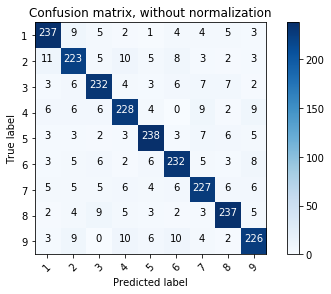

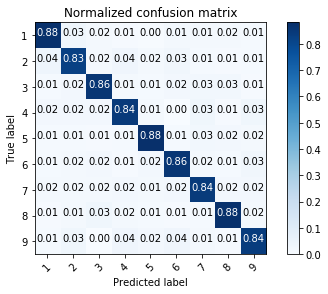

In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = np.array(pred) 
y_test = np.array(sn)
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names = [str(i+1) for i in range(9)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()










In [17]:
cnf_matrix

array([[237,   9,   5,   2,   1,   4,   4,   5,   3],
       [ 11, 223,   5,  10,   5,   8,   3,   2,   3],
       [  3,   6, 232,   4,   3,   6,   7,   7,   2],
       [  6,   6,   6, 228,   4,   0,   9,   2,   9],
       [  3,   3,   2,   3, 238,   3,   7,   6,   5],
       [  3,   5,   6,   2,   6, 232,   5,   3,   8],
       [  5,   5,   5,   6,   4,   6, 227,   6,   6],
       [  2,   4,   9,   5,   3,   2,   3, 237,   5],
       [  3,   9,   0,  10,   6,  10,   4,   2, 226]], dtype=int64)

In [18]:
# f1 = np.mean(2*[(precision*recall)/(precision+recall)])

F1 = []
for i in range(len(cnf_matrix)):
    tp = 0
    fp = 0
    fn = 0
    row = cnf_matrix[i,:]
    col = cnf_matrix[:,i]
    tp = cnf_matrix[i,i]
#     print(tp)
    fp = np.sum(col) - tp
#     print(fp)
    fn = np.sum(row) - tp
#     print(fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    F1.append(f1)
print(np.mean(F1))
    
    

0.85594464706
